In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib
import sklearn
import statsmodels

# Read the data as an appropriate Time Series data and plot the data.

In [2]:
df = pd.read_csv('Rose.csv', parse_dates=True, index_col='YearMonth')
df.head()

,Rose
YearMonth,
1980-01-01,112.0
1980-02-01,118.0
1980-03-01,129.0
1980-04-01,99.0
1980-05-01,116.0


In [3]:
from pylab import rcParams
rcParams['figure.figsize'] = 20,8

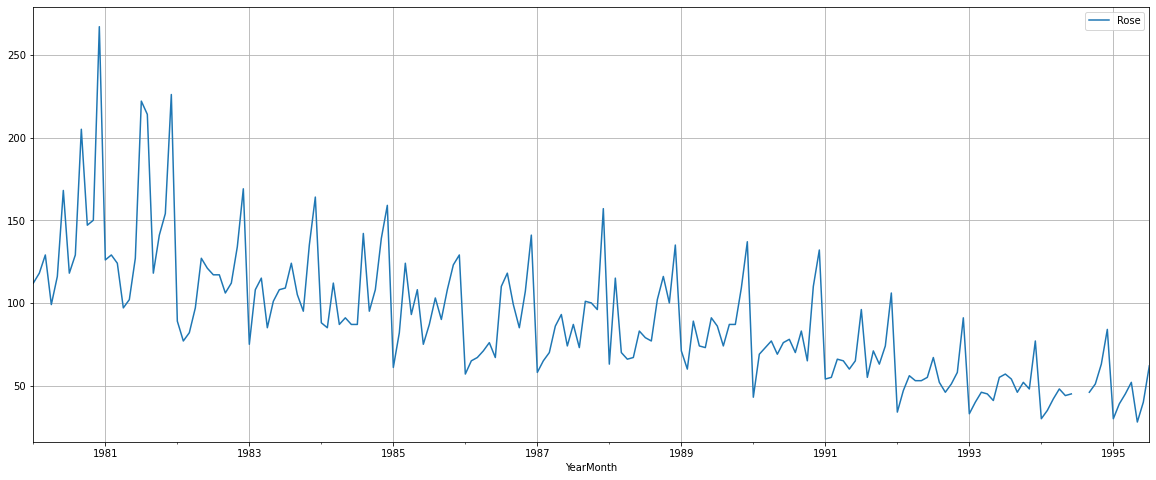

In [4]:
df.plot(grid=True);

# Perform appropriate Exploratory Data Analysis to understand the data and also perform decomposition.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 187 entries, 1980-01-01 to 1995-07-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Rose    185 non-null    float64
dtypes: float64(1)
memory usage: 2.9 KB


In [6]:
df[df['Rose'].isnull()]

,Rose
YearMonth,
1994-07-01,NaN
1994-08-01,NaN


In [7]:
df.loc['1994-07-01','Rose'] = (df.loc['1995-07-01','Rose'] + df.loc['1993-07-01','Rose'])/2
df.loc['1994-08-01','Rose'] = df.loc['1993-08-01','Rose'] - (df.loc['1992-08-01','Rose'] - df.loc['1993-08-01','Rose'])

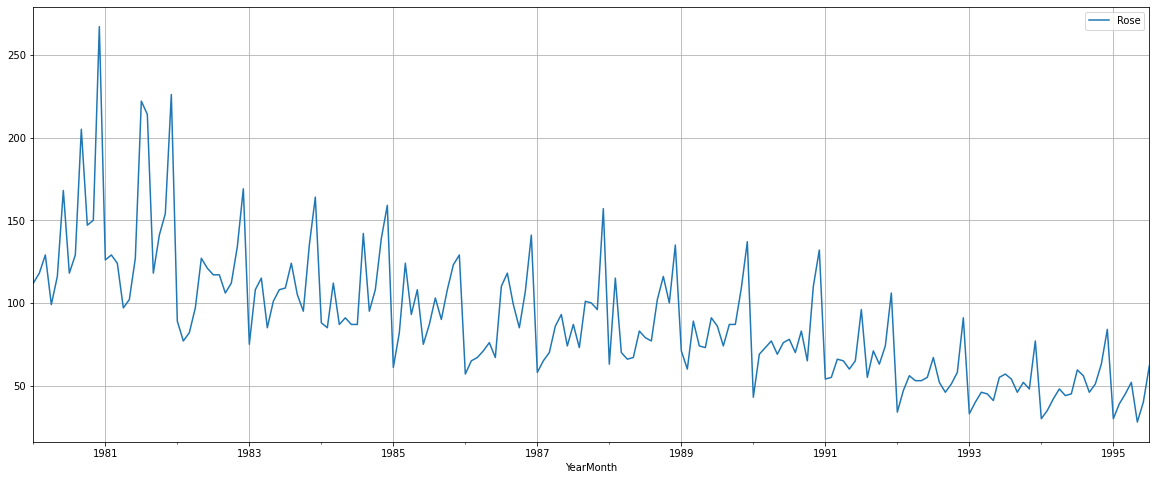

In [8]:
df.plot(grid=True);

In [9]:
df.describe()

,Rose
count,187.000000
mean,90.045455
std,39.109775
min,28.000000
25%,62.500000
50%,85.000000
75%,111.000000
max,267.000000


<AxesSubplot:xlabel='Rose'>

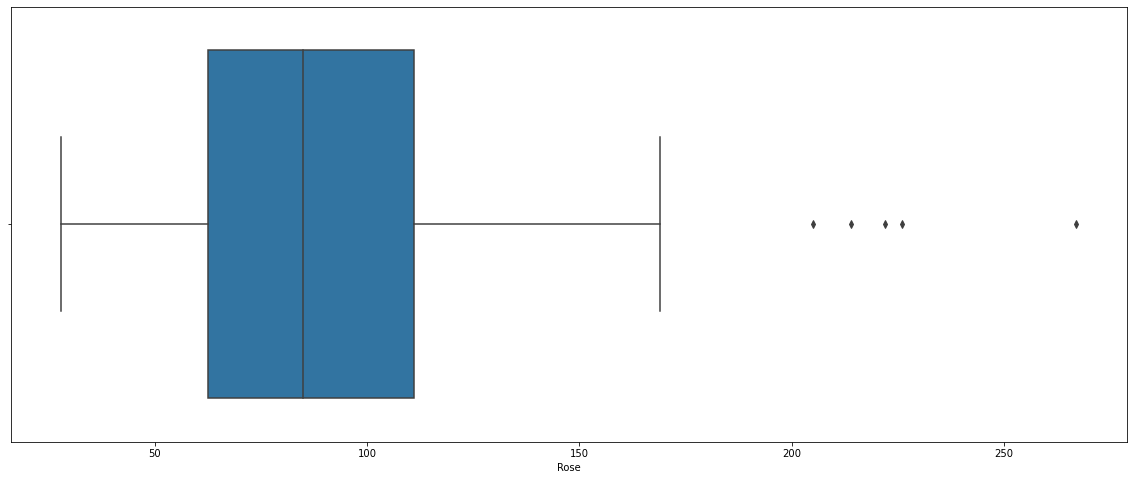

In [10]:
sns.boxplot(data=df, x='Rose')

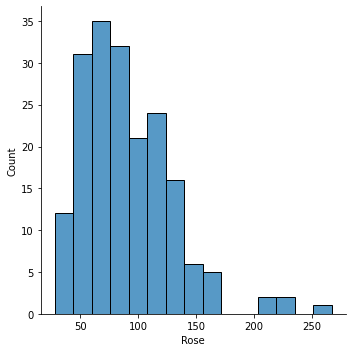

In [11]:
sns.displot(data=df, x='Rose')

In [12]:
from statsmodels.tsa.seasonal import seasonal_decompose

### Additive Decomposition

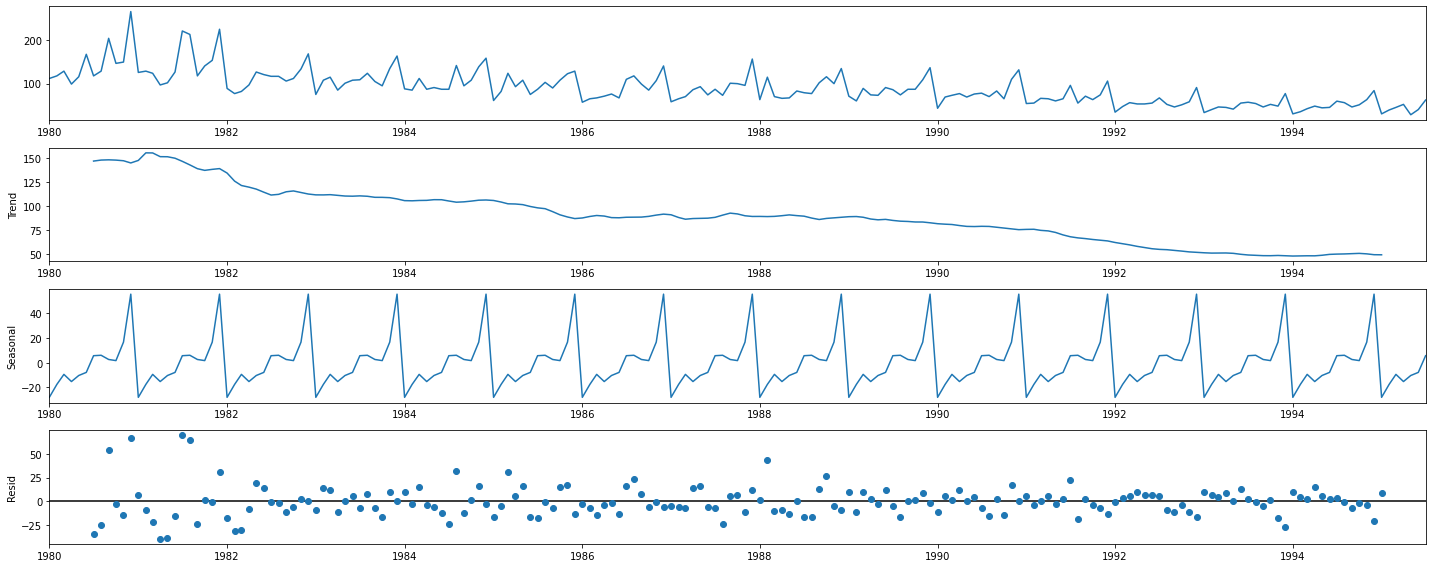

In [13]:
decomposition = seasonal_decompose(df,model='additive')
decomposition.plot();

We see that the residuals have a pattern in this decomposition.

### Multiplicative Decomposition

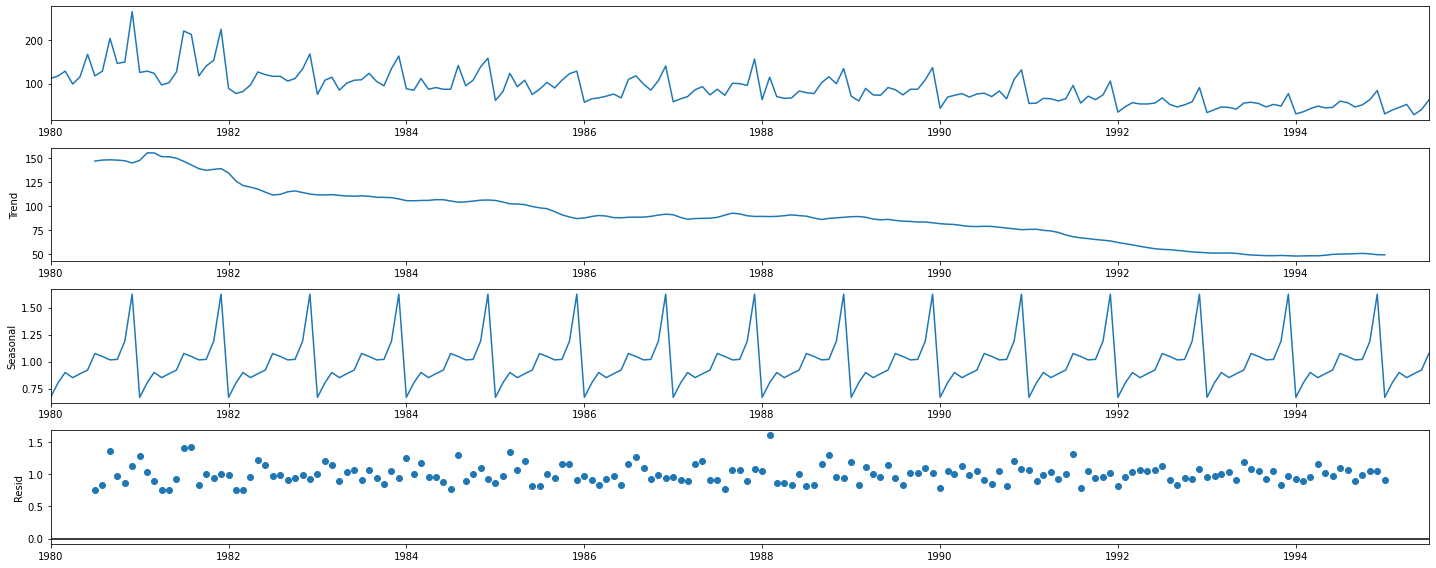

In [14]:
decomposition = seasonal_decompose(df,model='multiplicative')
decomposition.plot();

For the multiplicative series, we see that a lot of residuals are located around 1.

# Split the data into training and test. The test data should start in 1991.

In [15]:
train = df[df.index<='1990'] 
test = df[df.index>'1990']

# Build all the exponential smoothing models on the training data and evaluate the model using RMSE on the test data. Other models such as regression,naïve forecast models and simple average models. should also be built on the training data and check the performance on the test data using RMSE.

In [16]:
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from sklearn.metrics import  mean_squared_error
from sklearn.linear_model import LinearRegression

## Linear regression

In [17]:
LinearRegression_train = train.copy()
LinearRegression_test = test.copy()

In [18]:
lr = LinearRegression()

In [19]:
LinearRegression_train['x'] = [i+1 for i in range(len(train))]
LinearRegression_test['x'] = [i+len(train)+1 for i in range(len(test))]

In [20]:
lr.fit(LinearRegression_train[['x']],LinearRegression_train['Rose'])

LinearRegression()

In [21]:
test_predictions_model1 = lr.predict(LinearRegression_test[['x']])
LinearRegression_test['Pred'] = test_predictions_model1

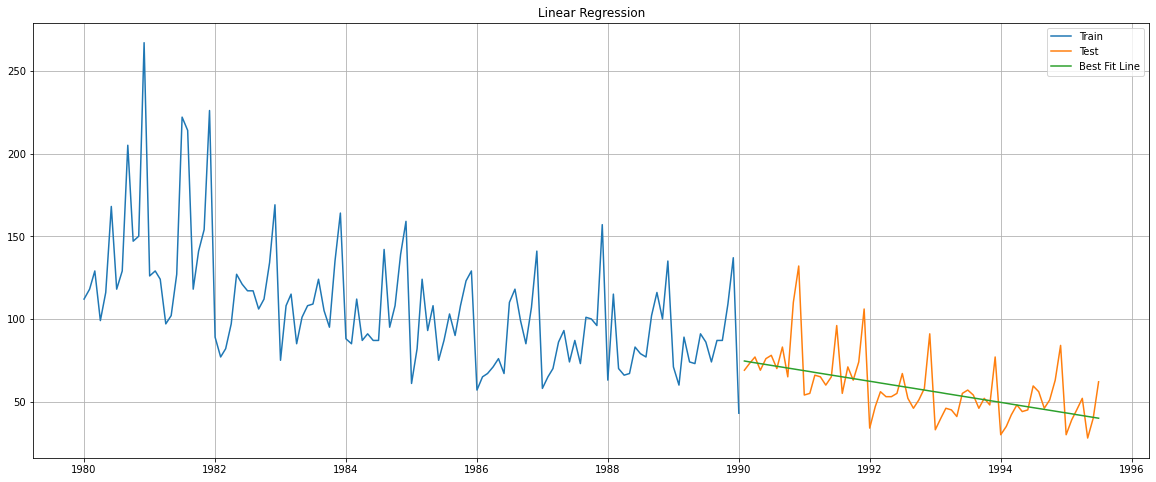

In [22]:
plt.plot(LinearRegression_train['Rose'], label='Train')
plt.plot(LinearRegression_test['Rose'], label='Test')
plt.plot(LinearRegression_test['Pred'], label='Best Fit Line')
plt.legend(loc='best')
plt.grid()
plt.title('Linear Regression');

In [23]:
resultsDf = pd.DataFrame({'RMSE': [mean_squared_error(LinearRegression_test['Rose'].values,LinearRegression_test['Pred'].values,squared=False)]},index=['LR'])
resultsDf

,RMSE
LR,16.408496


## Naive Model

In [24]:
Naive_train = train.copy()
Naive_test = test.copy()

In [25]:
Naive_test["Naive_Pred"] = Naive_train['Rose'][-1]

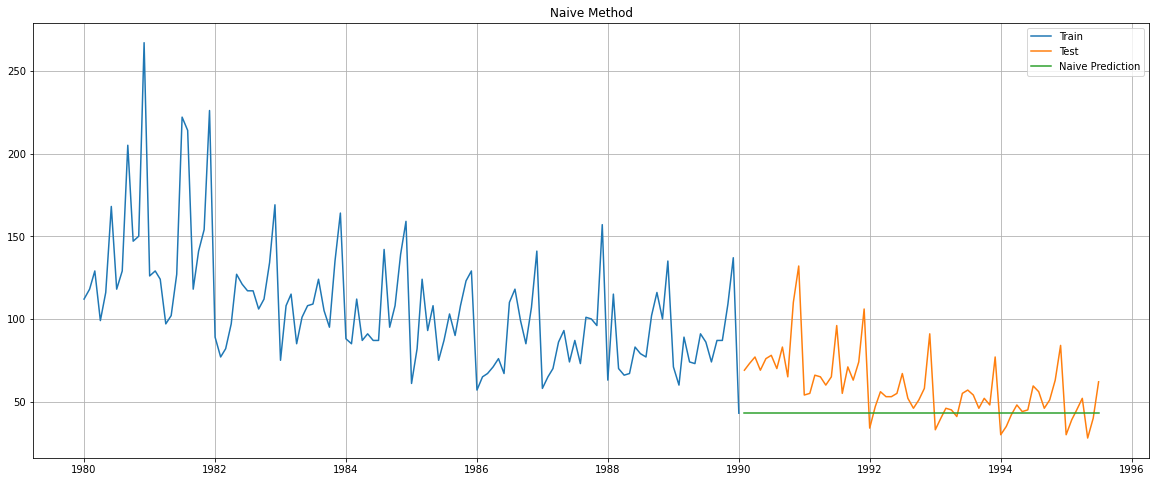

In [26]:
plt.plot(Naive_train['Rose'], label='Train')
plt.plot(Naive_test['Rose'], label='Test')
plt.plot(Naive_test['Naive_Pred'], label='Naive Prediction')
plt.legend(loc='best')
plt.grid()
plt.title('Naive Method');

In [27]:
resultsDf_temp = pd.DataFrame({'RMSE': [mean_squared_error(Naive_test['Rose'].values,Naive_test['Naive_Pred'].values,squared=False)]},index=['Naive'])
resultsDf = pd.concat([resultsDf, resultsDf_temp])
resultsDf

,RMSE
LR,16.408496
Naive,25.079948


## Simple Average Method

In [28]:
SimpleAverage_train = train.copy()
SimpleAverage_test = test.copy()

In [29]:
SimpleAverage_test['mean_forecast'] = SimpleAverage_train['Rose'].mean()

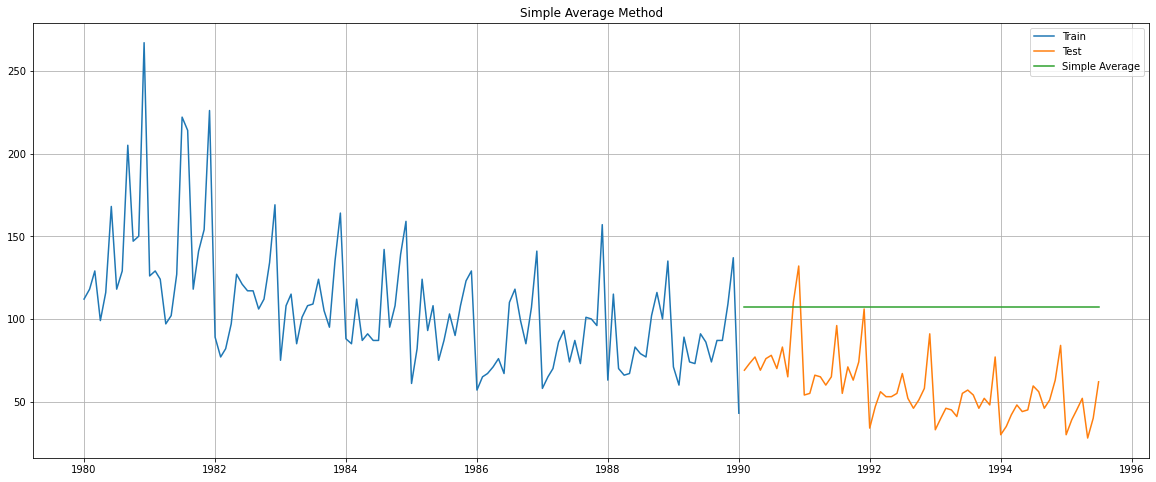

In [30]:
plt.plot(SimpleAverage_train['Rose'], label='Train')
plt.plot(SimpleAverage_test['Rose'], label='Test')
plt.plot(SimpleAverage_test['mean_forecast'], label='Simple Average')
plt.legend(loc='best')
plt.grid()
plt.title('Simple Average Method');

In [31]:
resultsDf_temp = pd.DataFrame({'RMSE': [mean_squared_error(SimpleAverage_test['Rose'].values,SimpleAverage_test['mean_forecast'].values,squared=False)]},index=['Average'])
resultsDf = pd.concat([resultsDf, resultsDf_temp])
resultsDf

,RMSE
LR,16.408496
Naive,25.079948
Average,51.865744


### SES -  ETS(A, N, N) - Simple Exponential Smoothing with additive errors

In [32]:
model_SES = SimpleExpSmoothing(train,initialization_method='estimated')
model_SES_autofit = model_SES.fit(optimized=True)
model_SES_autofit.params

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


{'smoothing_level': 0.09854542471612353,
 'smoothing_trend': nan,
 'smoothing_seasonal': nan,
 'damping_trend': nan,
 'initial_level': 134.3926789828763,
 'initial_trend': nan,
 'initial_seasons': array([], dtype=float64),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

In [33]:
SES_predict = model_SES_autofit.forecast(steps=len(test))
SES_predict

1990-02-01    88.085392
1990-03-01    88.085392
1990-04-01    88.085392
1990-05-01    88.085392
1990-06-01    88.085392
                ...    
1995-03-01    88.085392
1995-04-01    88.085392
1995-05-01    88.085392
1995-06-01    88.085392
1995-07-01    88.085392
Freq: MS, Length: 66, dtype: float64

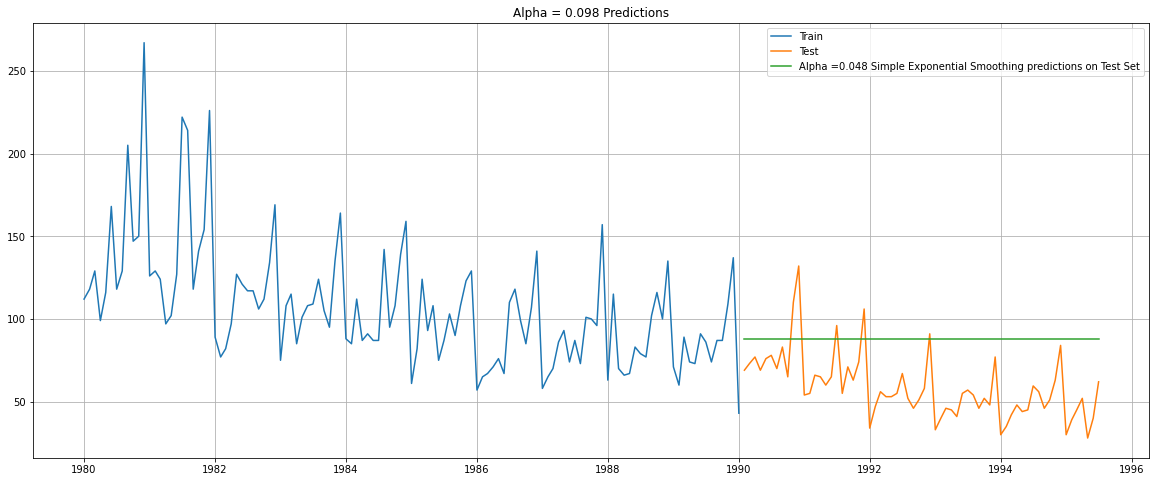

In [34]:
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.plot(SES_predict, label='Alpha =0.048 Simple Exponential Smoothing predictions on Test Set')
plt.legend(loc='best')
plt.grid()
plt.title('Alpha = 0.098 Predictions');

In [35]:
print('SES RMSE:',mean_squared_error(test.values,SES_predict.values,squared=False))

SES RMSE: 35.02110847181924


In [36]:
resultsDf_temp = pd.DataFrame({'RMSE': [mean_squared_error(test.values,SES_predict.values,squared=False)]},index=['SES (0.098)'])
resultsDf = pd.concat([resultsDf, resultsDf_temp])
resultsDf

,RMSE
LR,16.408496
Naive,25.079948
Average,51.865744
SES (0.098),35.021108


## Holt - ETS(A, A, N) - Holt's linear method with additive errors

In [37]:
model_DES = Holt(train,initialization_method='estimated')
model_DES = model_DES.fit()
model_DES.params

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


{'smoothing_level': 1.4901161193847656e-08,
 'smoothing_trend': 3.95400863275452e-09,
 'smoothing_seasonal': nan,
 'damping_trend': nan,
 'initial_level': 139.4809916744202,
 'initial_trend': -0.5320688317713194,
 'initial_seasons': array([], dtype=float64),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

In [38]:
DES_predict =  model_DES.forecast(len(test))
DES_predict

1990-02-01    74.568594
1990-03-01    74.036525
1990-04-01    73.504457
1990-05-01    72.972388
1990-06-01    72.440319
                ...    
1995-03-01    42.112395
1995-04-01    41.580327
1995-05-01    41.048258
1995-06-01    40.516189
1995-07-01    39.984120
Freq: MS, Length: 66, dtype: float64

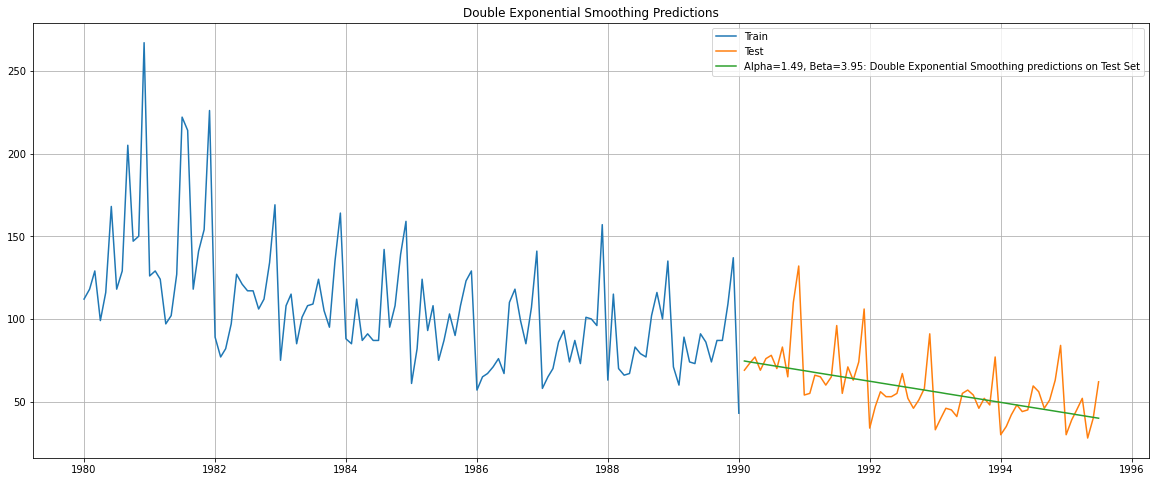

In [39]:
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.plot(DES_predict, label='Alpha=1.49, Beta=3.95: Double Exponential Smoothing predictions on Test Set')
plt.legend(loc='best')
plt.grid()
plt.title('Double Exponential Smoothing Predictions');

In [40]:
print('DES RMSE:',mean_squared_error(test.values,DES_predict.values,squared=False))

DES RMSE: 16.408495624749282


In [41]:
resultsDf_temp = pd.DataFrame({'RMSE': [mean_squared_error(test.values,DES_predict.values,squared=False)]}, index=['DES ((1.49, 3.95))'])
resultsDf = pd.concat([resultsDf, resultsDf_temp])
resultsDf

,RMSE
LR,16.408496
Naive,25.079948
Average,51.865744
SES (0.098),35.021108
"DES ((1.49, 3.95))",16.408496


### Holt-Winters - ETS(A, A, A) - Holt Winter's linear method with additive errors

In [42]:
model_TES = ExponentialSmoothing(train,trend='additive',seasonal='additive',initialization_method='estimated')
model_TES = model_TES.fit()
model_TES.params

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


{'smoothing_level': 0.08687800631851612,
 'smoothing_trend': 4.713913006898936e-05,
 'smoothing_seasonal': 0.0005133871501009462,
 'damping_trend': nan,
 'initial_level': 147.1286865002265,
 'initial_trend': -0.5662905591893606,
 'initial_seasons': array([-30.90434964, -19.50936138, -11.14205221, -23.27728312,
        -12.81543803,  -7.55939377,   3.11837302,  10.57979756,
          4.83746071,   4.49837478,  19.86930581,  64.15081315]),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

In [43]:
TES_predict =  model_TES.forecast(len(test))
TES_predict

1990-02-01    58.604769
1990-03-01    66.405756
1990-04-01    53.704289
1990-05-01    63.599809
1990-06-01    68.289542
                ...    
1995-03-01    32.428616
1995-04-01    19.727149
1995-05-01    29.622670
1995-06-01    34.312403
1995-07-01    44.423814
Freq: MS, Length: 66, dtype: float64

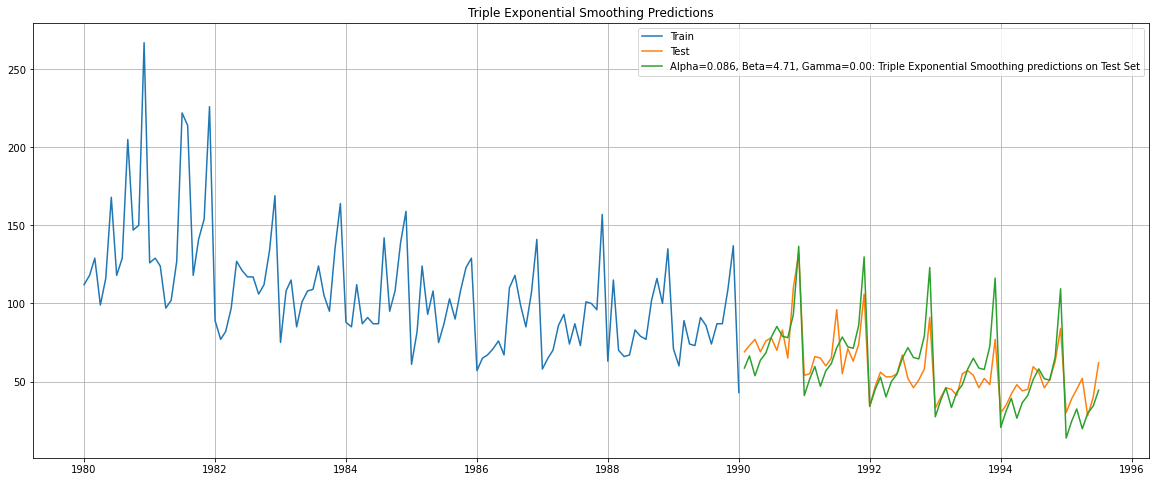

In [44]:
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.plot(TES_predict, label='Alpha=0.086, Beta=4.71, Gamma=0.00: Triple Exponential Smoothing predictions on Test Set')
plt.legend(loc='best')
plt.grid()
plt.title('Triple Exponential Smoothing Predictions');

In [45]:
print('TES RMSE:',mean_squared_error(test.values,TES_predict.values,squared=False))

TES RMSE: 13.887554272891077


In [46]:
resultsDf_temp = pd.DataFrame({'RMSE': [mean_squared_error(test.values,TES_predict.values,squared=False)]}, index=['TES A (0.086, 4.071, 0.00)'])
resultsDf = pd.concat([resultsDf, resultsDf_temp])
resultsDf

,RMSE
LR,16.408496
Naive,25.079948
Average,51.865744
SES (0.098),35.021108
"DES ((1.49, 3.95))",16.408496
"TES A (0.086, 4.071, 0.00)",13.887554


### Holt-Winters - ETS(A, A, M) - Holt Winter's linear method 

In [47]:
model_TES_am = ExponentialSmoothing(train,trend='add',seasonal='multiplicative',initialization_method='estimated')
model_TES_am = model_TES_am.fit()
model_TES_am.params

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


{'smoothing_level': 0.07974922107821987,
 'smoothing_trend': 0.03861114307592691,
 'smoothing_seasonal': 0.0011988352134338386,
 'damping_trend': nan,
 'initial_level': 130.8140012081654,
 'initial_trend': -0.7480367024416842,
 'initial_seasons': array([0.85613805, 0.96742911, 1.06006897, 0.91476161, 1.0439795 ,
        1.13478136, 1.25290816, 1.34637033, 1.25599053, 1.24477798,
        1.42236489, 1.97667154]),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

In [48]:
TES_predict_am =  model_TES_am.forecast(len(test))
TES_predict_am

1990-02-01    65.931569
1990-03-01    72.014845
1990-04-01    61.969723
1990-05-01    70.475172
1990-06-01    76.316564
                ...    
1995-03-01    58.631012
1995-04-01    50.416974
1995-05-01    57.295840
1995-06-01    62.000231
1995-07-01    68.200294
Freq: MS, Length: 66, dtype: float64

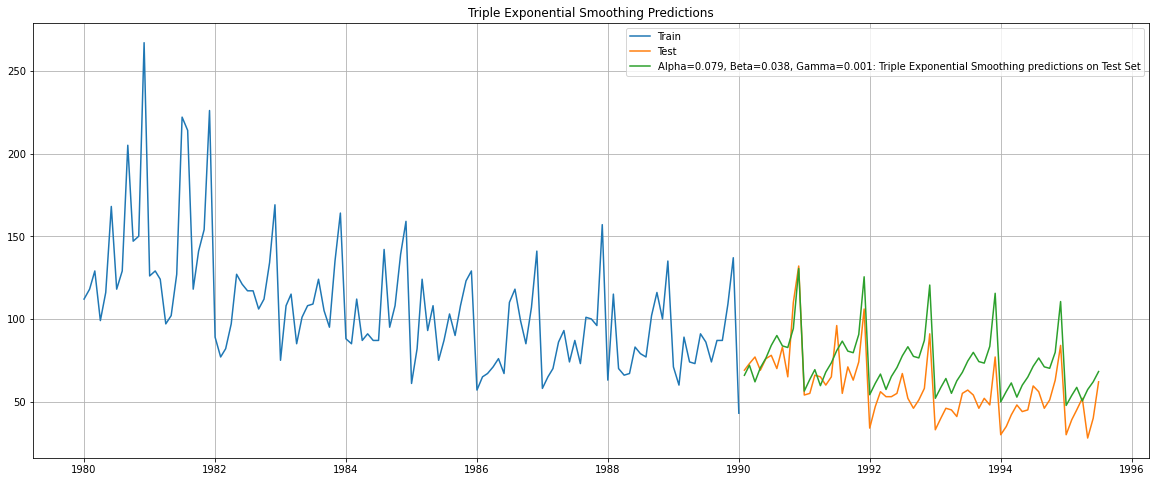

In [49]:
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.plot(TES_predict_am, label='Alpha=0.079, Beta=0.038, Gamma=0.001: Triple Exponential Smoothing predictions on Test Set')
plt.legend(loc='best')
plt.grid()
plt.title('Triple Exponential Smoothing Predictions');

In [50]:
print('TES_am RMSE:',mean_squared_error(test.values,TES_predict_am.values,squared=False))

TES_am RMSE: 18.48013833186913


In [51]:
resultsDf_temp = pd.DataFrame({'RMSE': [mean_squared_error(test.values,TES_predict_am.values,squared=False)]}, index=['TES M (0.079, 0.038, 0.001)'])
resultsDf = pd.concat([resultsDf, resultsDf_temp])
resultsDf

,RMSE
LR,16.408496
Naive,25.079948
Average,51.865744
SES (0.098),35.021108
"DES ((1.49, 3.95))",16.408496
"TES A (0.086, 4.071, 0.00)",13.887554
"TES M (0.079, 0.038, 0.001)",18.480138


# Check for the stationarity of the data on which the model is being built on using appropriate statistical tests and also mention the hypothesis for the statistical test. If the data is found to be non-stationary, take appropriate steps to make it stationary. Check the new data for stationarity and comment. Note: Stationarity should be checked at alpha = 0.05.

The Augmented Dickey-Fuller test is an unit root test which determines whether there is a unit root and subsequently whether the series is non-stationary.

The hypothesis in a simple form for the ADF test is:
* $H_0$ : The Time Series has a unit root and is thus non-stationary.
* $H_1$ : The Time Series does not have a unit root and is thus stationary.

We would want the series to be stationary for building ARIMA models and thus we would want the p-value of this test to be less than the $\alpha$ value.

In [52]:
from statsmodels.tsa.stattools import adfuller

In [53]:
dftest = adfuller(train,regression='ct')
print('DF test statistic is %3.3f' %dftest[0])
print('DF test p-value is' ,dftest[1])
print('Number of lags used' ,dftest[2])

DF test statistic is -1.536
DF test p-value is 0.8164868508229017
Number of lags used 13


The training data is non-stationary at 95% confidence level. Let us take a first level of differencing to stationarize the Time Series.

In [54]:
dftest = adfuller(train.diff().dropna(),regression='ct')
print('DF test statistic is %3.3f' %dftest[0])
print('DF test p-value is' ,dftest[1])
print('Number of lags used' ,dftest[2])

DF test statistic is -6.483
DF test p-value is 2.0063022190094543e-07
Number of lags used 12


The differenced training data is stationary at 95% confidence level.
Plotting the differenced training data for visualisation.

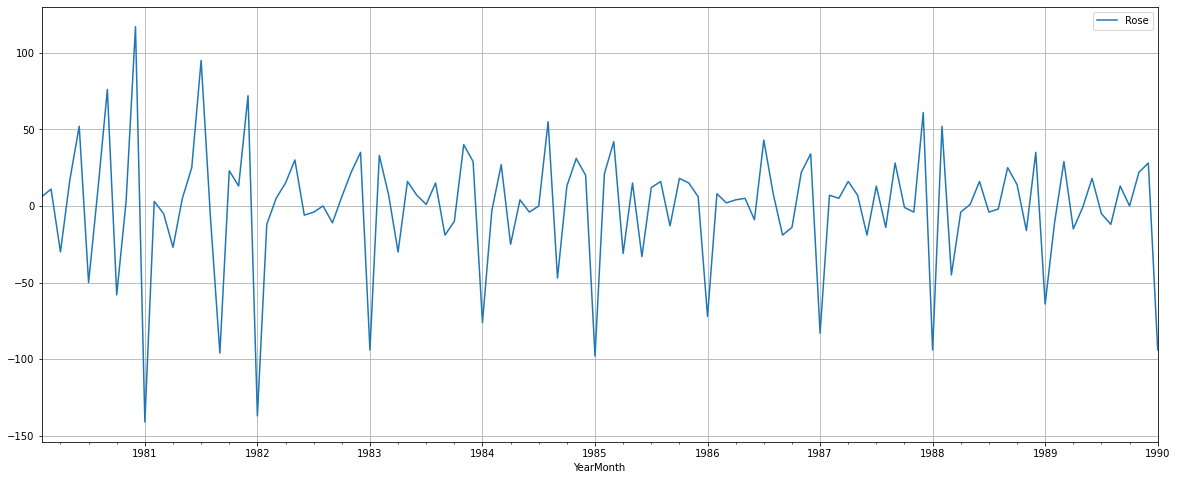

In [55]:
train.diff().dropna().plot(grid=True);

## Build an automated version of the ARIMA/SARIMA model in which the parameters are selected using the lowest Akaike Information Criteria (AIC) on the training data and evaluate this model on the test data using RMSE.

In [56]:
import itertools
p = q = range(0, 4)
d= range(1,2)
pdq = list(itertools.product(p, d, q))
print('Examples of the parameter combinations for the Model')
for i in range(0,len(pdq)):
    print('Model: {}'.format(pdq[i]))

Examples of the parameter combinations for the Model
Model: (0, 1, 0)
Model: (0, 1, 1)
Model: (0, 1, 2)
Model: (0, 1, 3)
Model: (1, 1, 0)
Model: (1, 1, 1)
Model: (1, 1, 2)
Model: (1, 1, 3)
Model: (2, 1, 0)
Model: (2, 1, 1)
Model: (2, 1, 2)
Model: (2, 1, 3)
Model: (3, 1, 0)
Model: (3, 1, 1)
Model: (3, 1, 2)
Model: (3, 1, 3)


In [57]:
ARIMA_AIC = pd.DataFrame(columns=['param', 'AIC'])
ARIMA_AIC

,param,AIC


In [58]:
from statsmodels.tsa.arima.model import ARIMA

for param in pdq:
    ARIMA_model = ARIMA(train['Rose'].values,order=param).fit()
    print('ARIMA{} - AIC:{}'.format(param,ARIMA_model.aic))
    ARIMA_AIC = ARIMA_AIC.append({'param':param, 'AIC': ARIMA_model.aic}, ignore_index=True)

ARIMA(0, 1, 0) - AIC:1229.5280224130197


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_2348\1652561359.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ARIMA_AIC = ARIMA_AIC.append({'param':param, 'AIC': ARIMA_model.aic}, ignore_index=True)
C:\Users\rkeswani\AppData\Local\Temp\ipykernel_2348\1652561359.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ARIMA_AIC = ARIMA_AIC.append({'param':param, 'AIC': ARIMA_model.aic}, ignore_index=True)
C:\Users\rkeswani\AppData\Local\Temp\ipykernel_2348\1652561359.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ARIMA_AIC = ARIMA_AIC.append({'param':param, 'AIC': ARIMA_model.aic}, ignore_index=True)


ARIMA(0, 1, 1) - AIC:1181.2402512168792
ARIMA(0, 1, 2) - AIC:1179.686490964611
ARIMA(0, 1, 3) - AIC:1180.4301462524836


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_2348\1652561359.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ARIMA_AIC = ARIMA_AIC.append({'param':param, 'AIC': ARIMA_model.aic}, ignore_index=True)
C:\Users\rkeswani\AppData\Local\Temp\ipykernel_2348\1652561359.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ARIMA_AIC = ARIMA_AIC.append({'param':param, 'AIC': ARIMA_model.aic}, ignore_index=True)
C:\Users\rkeswani\AppData\Local\Temp\ipykernel_2348\1652561359.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ARIMA_AIC = ARIMA_AIC.append({'param':param, 'AIC': ARIMA_model.aic}, ignore_index=True)


ARIMA(1, 1, 0) - AIC:1215.065376288531
ARIMA(1, 1, 1) - AIC:1180.4214378859847
ARIMA(1, 1, 2) - AIC:1179.8085176532215
ARIMA(1, 1, 3) - AIC:1181.7911310052891
ARIMA(2, 1, 0) - AIC:1197.1529047135255


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_2348\1652561359.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ARIMA_AIC = ARIMA_AIC.append({'param':param, 'AIC': ARIMA_model.aic}, ignore_index=True)
C:\Users\rkeswani\AppData\Local\Temp\ipykernel_2348\1652561359.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ARIMA_AIC = ARIMA_AIC.append({'param':param, 'AIC': ARIMA_model.aic}, ignore_index=True)
C:\Users\rkeswani\AppData\Local\Temp\ipykernel_2348\1652561359.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ARIMA_AIC = ARIMA_AIC.append({'param':param, 'AIC': ARIMA_model.aic}, ignore_index=True)
C:\Users\rkeswani\AppData\Local\Temp\ipykernel_2348\1652561359.py:6: FutureWarning: The frame.append method is deprecated

ARIMA(2, 1, 1) - AIC:1181.3680079395017
ARIMA(2, 1, 2) - AIC:1181.7876578571868


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_2348\1652561359.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ARIMA_AIC = ARIMA_AIC.append({'param':param, 'AIC': ARIMA_model.aic}, ignore_index=True)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\rkeswani\AppData\Local\Temp\ipykernel_2348\1652561359.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ARIMA_AIC = ARIMA_AIC.append({'param':param, 'AIC': ARIMA_model.aic}, ignore_index=True)
C:\Users\rkeswani\AppData\Local\Temp\ipykernel_2348\1652561359.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.con

ARIMA(2, 1, 3) - AIC:1173.8824169058373
ARIMA(3, 1, 0) - AIC:1196.236723286314
ARIMA(3, 1, 1) - AIC:1182.3082022019812


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_2348\1652561359.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ARIMA_AIC = ARIMA_AIC.append({'param':param, 'AIC': ARIMA_model.aic}, ignore_index=True)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA(3, 1, 2) - AIC:1183.634142143539


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_2348\1652561359.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ARIMA_AIC = ARIMA_AIC.append({'param':param, 'AIC': ARIMA_model.aic}, ignore_index=True)


ARIMA(3, 1, 3) - AIC:1175.8820918570764


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\rkeswani\AppData\Local\Temp\ipykernel_2348\1652561359.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ARIMA_AIC = ARIMA_AIC.append({'param':param, 'AIC': ARIMA_model.aic}, ignore_index=True)


In [59]:
ARIMA_AIC.sort_values(by='AIC',ascending=True).head()

,param,AIC
11,"(2, 1, 3)",1173.882417
15,"(3, 1, 3)",1175.882092
2,"(0, 1, 2)",1179.686491
6,"(1, 1, 2)",1179.808518
5,"(1, 1, 1)",1180.421438


In [60]:
auto_ARIMA = ARIMA(train, order=(2,1,3))
results_auto_ARIMA = auto_ARIMA.fit()
print(results_auto_ARIMA.summary())

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                   Rose   No. Observations:                  121
Model:                 ARIMA(2, 1, 3)   Log Likelihood                -580.941
Date:                Sun, 19 Feb 2023   AIC                           1173.882
Time:                        17:10:31   BIC                           1190.607
Sample:                    01-01-1980   HQIC                          1180.674
                         - 01-01-1990                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.6490      0.089    -18.443      0.000      -1.824      -1.474
ar.L2         -0.7002      0.091     -7.720      0.000      -0.878      -0.522
ma.L1          1.0452      1.650      0.634      0.5

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Diagnostics plot.

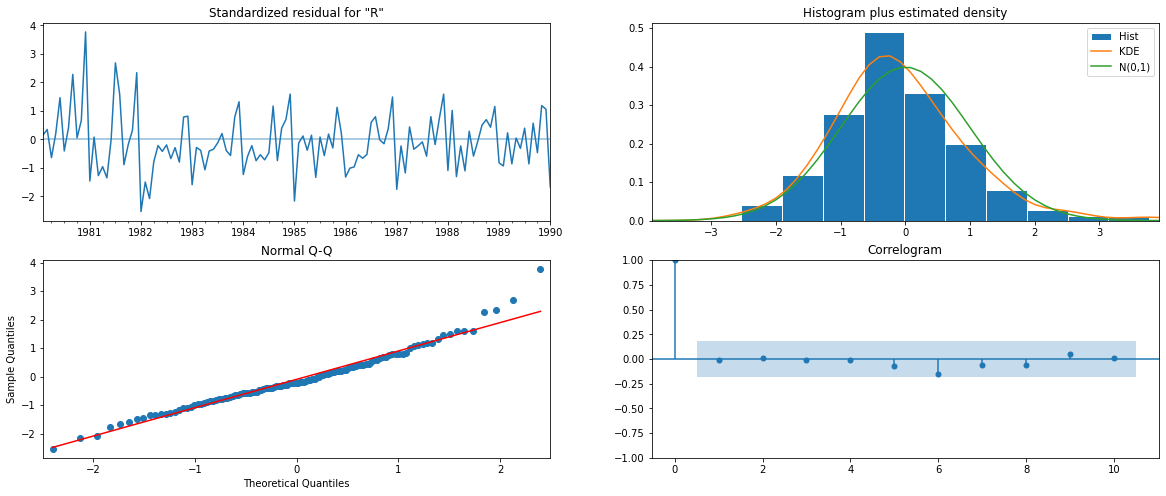

In [61]:
results_auto_ARIMA.plot_diagnostics();

## Predict on the Test Set using this model and evaluate the model.

In [62]:
predicted_auto_ARIMA = results_auto_ARIMA.forecast(steps=len(test))

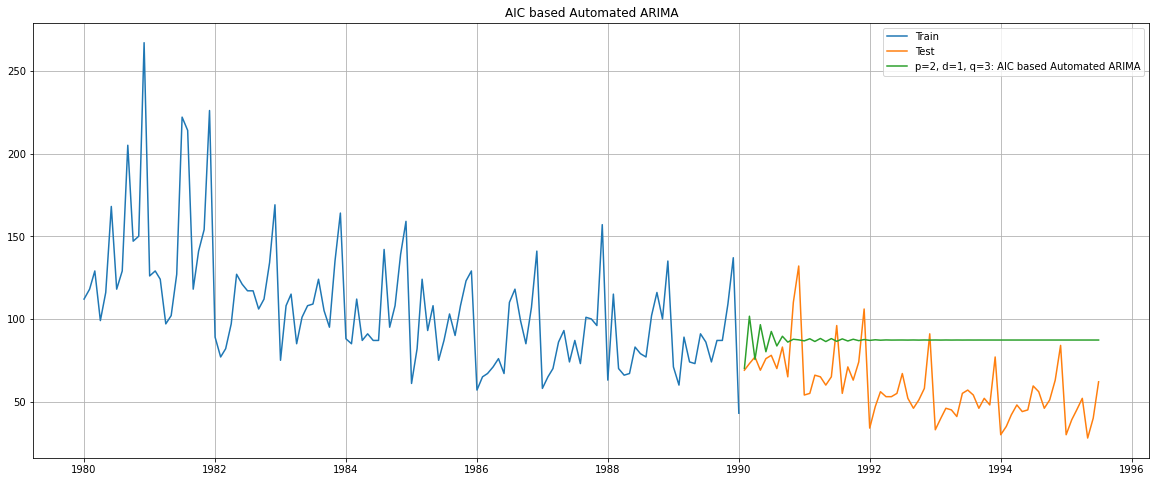

In [63]:
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.plot(predicted_auto_ARIMA, label='p=2, d=1, q=3: AIC based Automated ARIMA')
plt.legend(loc='best')
plt.grid()
plt.title('AIC based Automated ARIMA');

In [64]:
rmse = mean_squared_error(test['Rose'],predicted_auto_ARIMA,squared=False)
print('RMSE:',rmse)

RMSE: 34.43448772531559


In [65]:
resultsDf_temp = pd.DataFrame({'RMSE': rmse}, index=['AUTO ARIMA (2, 1, 3)'])
resultsDf = pd.concat([resultsDf, resultsDf_temp])
resultsDf

,RMSE
LR,16.408496
Naive,25.079948
Average,51.865744
SES (0.098),35.021108
"DES ((1.49, 3.95))",16.408496
"TES A (0.086, 4.071, 0.00)",13.887554
"TES M (0.079, 0.038, 0.001)",18.480138
"AUTO ARIMA (2, 1, 3)",34.434488


## Build a version of the ARIMA model for which the best parameters are selected by looking at the ACF and the PACF plots.

Let us look at the ACF and the PACF plots.

In [66]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

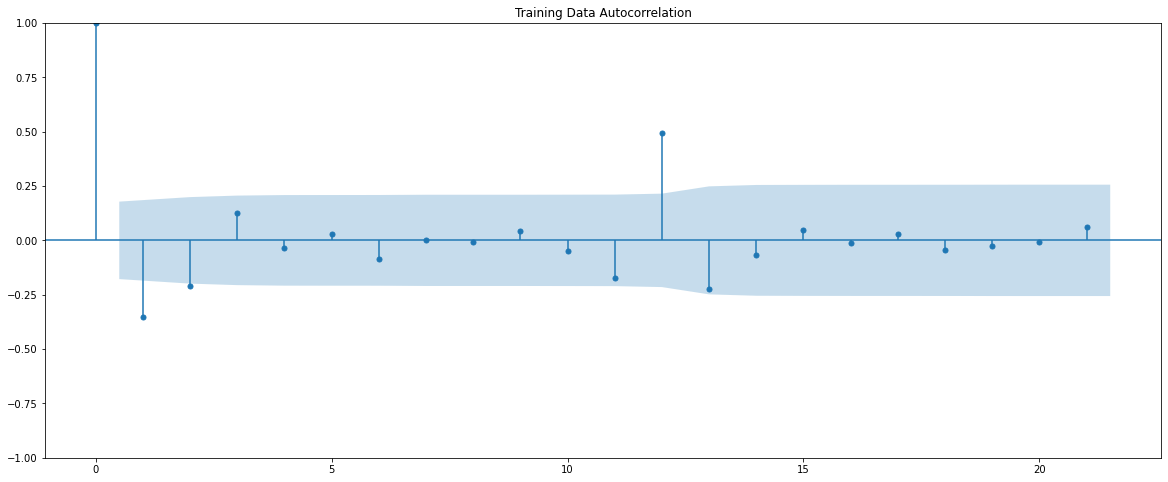

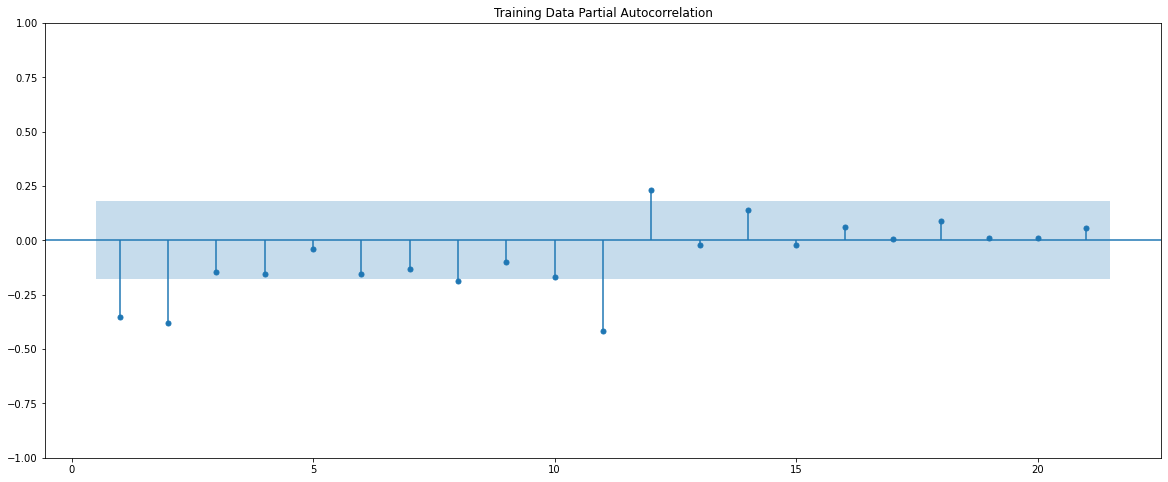

In [67]:
plot_acf(train.diff(),title='Training Data Autocorrelation',missing='drop')
plot_pacf(train.diff().dropna(),title='Training Data Partial Autocorrelation',zero=False,method='ywmle')
plt.show()

Here, we have taken alpha=0.05.

* The Auto-Regressive parameter in an ARIMA model is 'p' which comes from the significant lag before which the PACF plot cuts-off to 2.
* The Moving-Average parameter in an ARIMA model is 'q' which comes from the significant lag before the ACF plot cuts-off to 2.

By looking at the above plots, we will take the value of p and q to be 2 and 2 respectively.

In [68]:
manual_ARIMA = ARIMA(train['Rose'], order=(2,1,2))
results_manual_ARIMA = manual_ARIMA.fit()
print(results_manual_ARIMA.summary())

                               SARIMAX Results                                
Dep. Variable:                   Rose   No. Observations:                  121
Model:                 ARIMA(2, 1, 2)   Log Likelihood                -585.894
Date:                Sun, 19 Feb 2023   AIC                           1181.788
Time:                        17:10:33   BIC                           1195.725
Sample:                    01-01-1980   HQIC                          1187.448
                         - 01-01-1990                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4601      0.484     -0.950      0.342      -1.410       0.489
ar.L2         -0.0169      0.174     -0.097      0.923      -0.357       0.324
ma.L1         -0.2583      0.473     -0.546      0.5

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Let us analyse the residuals from the various diagnostics plot.

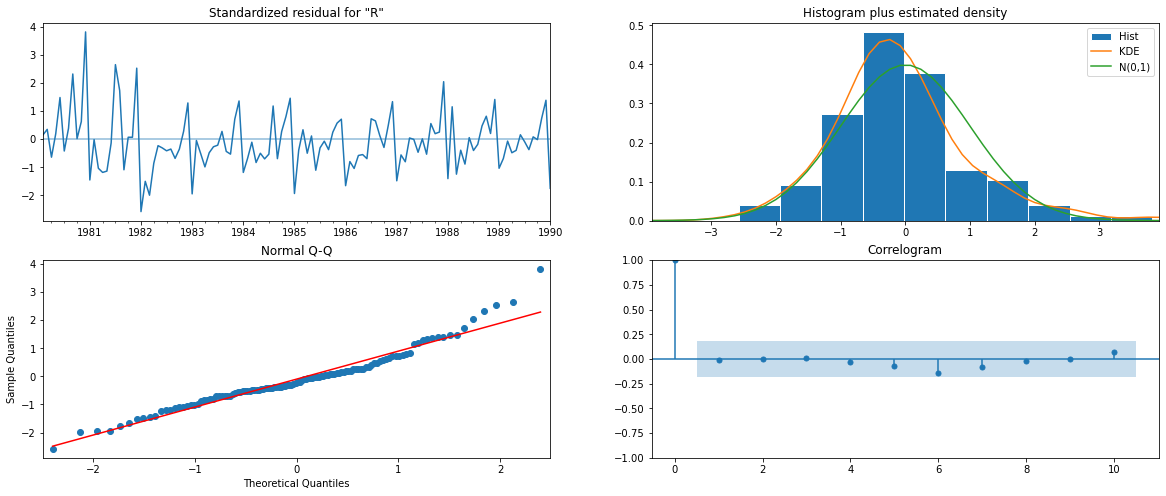

In [69]:
results_manual_ARIMA.plot_diagnostics();

## Predict on the Test Set using this model and evaluate the model.

In [70]:
predicted_manual_ARIMA = results_manual_ARIMA.forecast(steps=len(test))

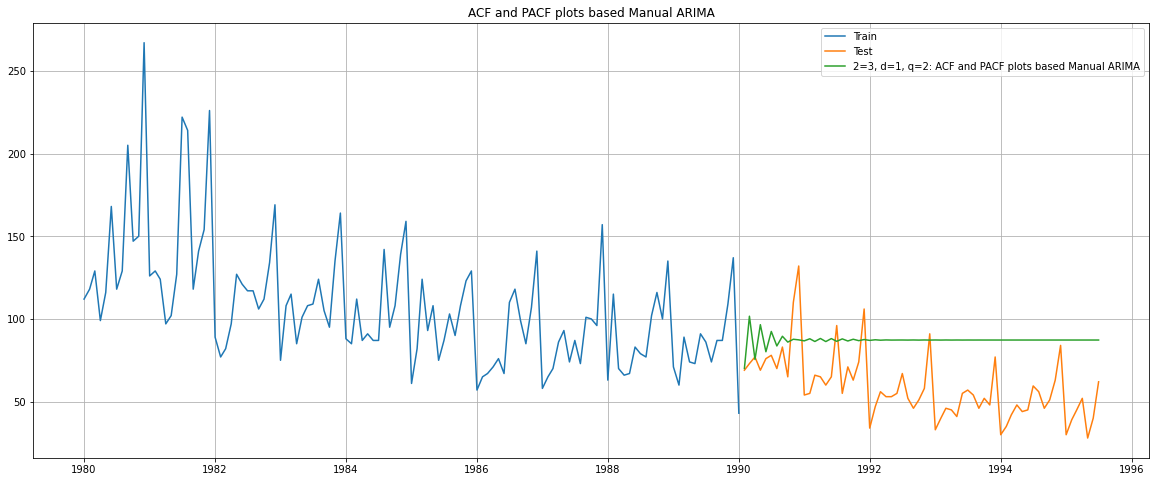

In [71]:
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.plot(predicted_auto_ARIMA, label='2=3, d=1, q=2: ACF and PACF plots based Manual ARIMA')
plt.legend(loc='best')
plt.grid()
plt.title('ACF and PACF plots based Manual ARIMA');

In [72]:
rmse = mean_squared_error(test['Rose'],predicted_manual_ARIMA,squared=False)
print('RMSE:',rmse)

RMSE: 34.38236068986562


In [73]:
temp_resultsDf = pd.DataFrame({'RMSE': rmse}, index=['MANUAL ARIMA (2, 1, 2)'])
resultsDf = pd.concat([resultsDf,temp_resultsDf])
resultsDf

,RMSE
LR,16.408496
Naive,25.079948
Average,51.865744
SES (0.098),35.021108
"DES ((1.49, 3.95))",16.408496
"TES A (0.086, 4.071, 0.00)",13.887554
"TES M (0.079, 0.038, 0.001)",18.480138
"AUTO ARIMA (2, 1, 3)",34.434488
"MANUAL ARIMA (2, 1, 2)",34.382361


## Build an Automated version of a SARIMA model for which the best parameters are selected in accordance with the lowest Akaike Information Criteria (AIC).

Let us look at the ACF plot once more to understand the seasonal parameter for the SARIMA model.

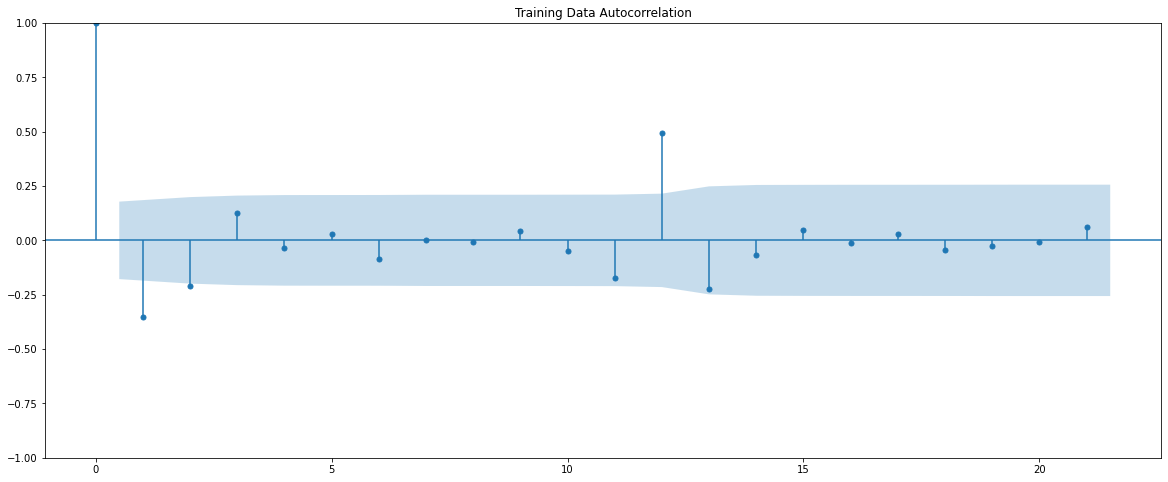

In [74]:
plot_acf(train.diff(),title='Training Data Autocorrelation',missing='drop');

We can see that there is a seasonality.

In [75]:
import itertools
p = q = range(0, 4)
d= range(1,2)
D = range(0,1)
pdq = list(itertools.product(p, d, q))
PDQ = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, D, q))]
print('Examples of the parameter combinations for the Model are')
for i in range(1,len(pdq)):
    print('Model: {}{}'.format(pdq[i], PDQ[i]))

Examples of the parameter combinations for the Model are
Model: (0, 1, 1)(0, 0, 1, 12)
Model: (0, 1, 2)(0, 0, 2, 12)
Model: (0, 1, 3)(0, 0, 3, 12)
Model: (1, 1, 0)(1, 0, 0, 12)
Model: (1, 1, 1)(1, 0, 1, 12)
Model: (1, 1, 2)(1, 0, 2, 12)
Model: (1, 1, 3)(1, 0, 3, 12)
Model: (2, 1, 0)(2, 0, 0, 12)
Model: (2, 1, 1)(2, 0, 1, 12)
Model: (2, 1, 2)(2, 0, 2, 12)
Model: (2, 1, 3)(2, 0, 3, 12)
Model: (3, 1, 0)(3, 0, 0, 12)
Model: (3, 1, 1)(3, 0, 1, 12)
Model: (3, 1, 2)(3, 0, 2, 12)
Model: (3, 1, 3)(3, 0, 3, 12)


In [76]:
SARIMA_AIC = pd.DataFrame(columns=['param','seasonal', 'AIC'])
SARIMA_AIC

,param,seasonal,AIC


In [77]:
import statsmodels.api as sm

for param in pdq:
    for param_seasonal in PDQ:
        SARIMA_model = sm.tsa.statespace.SARIMAX(train['Rose'].values,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            
        results_SARIMA = SARIMA_model.fit(maxiter=1000)
        print('SARIMA{}x{} - AIC:{}'.format(param, param_seasonal, results_SARIMA.aic))
        SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)

SARIMA(0, 1, 0)x(0, 0, 0, 12) - AIC:1220.2724344111418
SARIMA(0, 1, 0)x(0, 0, 1, 12) - AIC:1045.0345424431914


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_2348\1537112383.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
C:\Users\rkeswani\AppData\Local\Temp\ipykernel_2348\1537112383.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(0, 1, 0)x(0, 0, 2, 12) - AIC:880.2544862446089


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_2348\1537112383.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\rkeswani\AppData\Local\Temp\ipykernel_2348\1537112383.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
C:\Users\rkeswani\AppData\Local\Temp\ipykernel_2348\1537112383.py:13: FutureWarning: The frame.append method is deprecated an

SARIMA(0, 1, 0)x(0, 0, 3, 12) - AIC:2542.0395732421093
SARIMA(0, 1, 0)x(1, 0, 0, 12) - AIC:1042.1359577001588
SARIMA(0, 1, 0)x(1, 0, 1, 12) - AIC:1020.0507654656935


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_2348\1537112383.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(0, 1, 0)x(1, 0, 2, 12) - AIC:874.8104078101352


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_2348\1537112383.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\rkeswani\AppData\Local\Temp\ipykernel_2348\1537112383.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
C:\Users\rkeswani\AppData\Local\Temp\ipykernel_2348\1537112383.py:13: FutureWarning: The frame.append method is deprecated an

SARIMA(0, 1, 0)x(1, 0, 3, 12) - AIC:3245.7938864432404
SARIMA(0, 1, 0)x(2, 0, 0, 12) - AIC:867.5936316485916
SARIMA(0, 1, 0)x(2, 0, 1, 12) - AIC:869.5862184014125


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_2348\1537112383.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(0, 1, 0)x(2, 0, 2, 12) - AIC:862.6969612421475


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_2348\1537112383.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\rkeswani\AppData\Local\Temp\ipykernel_2348\1537112383.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(0, 1, 0)x(2, 0, 3, 12) - AIC:3135.4839139572373
SARIMA(0, 1, 0)x(3, 0, 0, 12) - AIC:757.8899566088122


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_2348\1537112383.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(0, 1, 0)x(3, 0, 1, 12) - AIC:759.46692053064


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_2348\1537112383.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(0, 1, 0)x(3, 0, 2, 12) - AIC:757.8461447771954


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_2348\1537112383.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\rkeswani\AppData\Local\Temp\ipykernel_2348\1537112383.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
C:\Users\rkeswani\AppData\Local\Temp\ipykernel_2348\1537112383.py:13: FutureWarning: The frame.append method is deprecated an

SARIMA(0, 1, 0)x(3, 0, 3, 12) - AIC:3010.7082880094335
SARIMA(0, 1, 1)x(0, 0, 0, 12) - AIC:1162.3982385813097
SARIMA(0, 1, 1)x(0, 0, 1, 12) - AIC:1003.4007235816529


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_2348\1537112383.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(0, 1, 1)x(0, 0, 2, 12) - AIC:832.0273585193756


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_2348\1537112383.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\rkeswani\AppData\Local\Temp\ipykernel_2348\1537112383.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(0, 1, 1)x(0, 0, 3, 12) - AIC:1915.734234225315
SARIMA(0, 1, 1)x(1, 0, 0, 12) - AIC:1003.2323860787011


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_2348\1537112383.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
C:\Users\rkeswani\AppData\Local\Temp\ipykernel_2348\1537112383.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(0, 1, 1)x(1, 0, 1, 12) - AIC:963.9786468413245
SARIMA(0, 1, 1)x(1, 0, 2, 12) - AIC:828.5902626802801


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_2348\1537112383.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\rkeswani\AppData\Local\Temp\ipykernel_2348\1537112383.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(0, 1, 1)x(1, 0, 3, 12) - AIC:3131.769668238377
SARIMA(0, 1, 1)x(2, 0, 0, 12) - AIC:826.235812932458


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_2348\1537112383.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(0, 1, 1)x(2, 0, 1, 12) - AIC:827.525193154725


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_2348\1537112383.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(0, 1, 1)x(2, 0, 2, 12) - AIC:813.4230542494449


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_2348\1537112383.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(0, 1, 1)x(2, 0, 3, 12) - AIC:3205.717106449333


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_2348\1537112383.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(0, 1, 1)x(3, 0, 0, 12) - AIC:713.7337323694132


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_2348\1537112383.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(0, 1, 1)x(3, 0, 1, 12) - AIC:715.639496252202


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_2348\1537112383.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(0, 1, 1)x(3, 0, 2, 12) - AIC:717.1072791063972


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_2348\1537112383.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(0, 1, 1)x(3, 0, 3, 12) - AIC:3320.1129041080153
SARIMA(0, 1, 2)x(0, 0, 0, 12) - AIC:1151.5689148438935


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_2348\1537112383.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
C:\Users\rkeswani\AppData\Local\Temp\ipykernel_2348\1537112383.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(0, 1, 2)x(0, 0, 1, 12) - AIC:988.0170676567694


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_2348\1537112383.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(0, 1, 2)x(0, 0, 2, 12) - AIC:822.4285377106455


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_2348\1537112383.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\rkeswani\AppData\Local\Temp\ipykernel_2348\1537112383.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(0, 1, 2)x(0, 0, 3, 12) - AIC:1553.925883923573
SARIMA(0, 1, 2)x(1, 0, 0, 12) - AIC:996.5258754155052


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_2348\1537112383.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(0, 1, 2)x(1, 0, 1, 12) - AIC:955.0435313222074


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_2348\1537112383.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(0, 1, 2)x(1, 0, 2, 12) - AIC:816.1529752645918


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_2348\1537112383.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\rkeswani\AppData\Local\Temp\ipykernel_2348\1537112383.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(0, 1, 2)x(1, 0, 3, 12) - AIC:2336.3242816759957
SARIMA(0, 1, 2)x(2, 0, 0, 12) - AIC:825.6372944060736


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_2348\1537112383.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(0, 1, 2)x(2, 0, 1, 12) - AIC:827.141751137272


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_2348\1537112383.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(0, 1, 2)x(2, 0, 2, 12) - AIC:801.2973797886175


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_2348\1537112383.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\rkeswani\AppData\Local\Temp\ipykernel_2348\1537112383.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(0, 1, 2)x(2, 0, 3, 12) - AIC:2050.770237792305
SARIMA(0, 1, 2)x(3, 0, 0, 12) - AIC:715.2792598478549


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_2348\1537112383.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(0, 1, 2)x(3, 0, 1, 12) - AIC:717.1812097065349


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_2348\1537112383.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(0, 1, 2)x(3, 0, 2, 12) - AIC:718.437484407329


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_2348\1537112383.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\rkeswani\AppData\Local\Temp\ipykernel_2348\1537112383.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(0, 1, 2)x(3, 0, 3, 12) - AIC:2360.6217424521355
SARIMA(0, 1, 3)x(0, 0, 0, 12) - AIC:1143.6116560283303


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_2348\1537112383.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(0, 1, 3)x(0, 0, 1, 12) - AIC:981.0377216369368


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_2348\1537112383.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(0, 1, 3)x(0, 0, 2, 12) - AIC:814.688442685839


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_2348\1537112383.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\rkeswani\AppData\Local\Temp\ipykernel_2348\1537112383.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(0, 1, 3)x(0, 0, 3, 12) - AIC:1569.8279253987841
SARIMA(0, 1, 3)x(1, 0, 0, 12) - AIC:996.719649785544


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_2348\1537112383.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(0, 1, 3)x(1, 0, 1, 12) - AIC:943.9775487461341


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_2348\1537112383.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(0, 1, 3)x(1, 0, 2, 12) - AIC:807.2001458488179


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_2348\1537112383.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\rkeswani\AppData\Local\Temp\ipykernel_2348\1537112383.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(0, 1, 3)x(1, 0, 3, 12) - AIC:3315.508277451204
SARIMA(0, 1, 3)x(2, 0, 0, 12) - AIC:827.5618715426515


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_2348\1537112383.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(0, 1, 3)x(2, 0, 1, 12) - AIC:828.9938639408438


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_2348\1537112383.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(0, 1, 3)x(2, 0, 2, 12) - AIC:793.720259657253


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_2348\1537112383.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\rkeswani\AppData\Local\Temp\ipykernel_2348\1537112383.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(0, 1, 3)x(2, 0, 3, 12) - AIC:3209.34720660036
SARIMA(0, 1, 3)x(3, 0, 0, 12) - AIC:717.2549855385921


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_2348\1537112383.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(0, 1, 3)x(3, 0, 1, 12) - AIC:719.173458069458


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_2348\1537112383.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(0, 1, 3)x(3, 0, 2, 12) - AIC:720.4095071975437


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_2348\1537112383.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(0, 1, 3)x(3, 0, 3, 12) - AIC:3226.756307130408
SARIMA(1, 1, 0)x(0, 0, 0, 12) - AIC:1205.8039116214666
SARIMA(1, 1, 0)x(0, 0, 1, 12) - AIC:1038.5173661108727


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_2348\1537112383.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
C:\Users\rkeswani\AppData\Local\Temp\ipykernel_2348\1537112383.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
C:\Users\rkeswani\AppData\Local\Temp\ipykernel_2348\1537112383.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(1, 1, 0)x(0, 0, 2, 12) - AIC:869.2459412990593


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_2348\1537112383.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\rkeswani\AppData\Local\Temp\ipykernel_2348\1537112383.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
C:\Users\rkeswani\AppData\Local\Temp\ipykernel_2348\1537112383.py:13: FutureWarning: The frame.append method is deprecated an

SARIMA(1, 1, 0)x(0, 0, 3, 12) - AIC:2195.734932032563
SARIMA(1, 1, 0)x(1, 0, 0, 12) - AIC:1028.901866788793
SARIMA(1, 1, 0)x(1, 0, 1, 12) - AIC:1011.7401920508481


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_2348\1537112383.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(1, 1, 0)x(1, 0, 2, 12) - AIC:864.6058104570985


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_2348\1537112383.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\rkeswani\AppData\Local\Temp\ipykernel_2348\1537112383.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(1, 1, 0)x(1, 0, 3, 12) - AIC:3421.2239317823874
SARIMA(1, 1, 0)x(2, 0, 0, 12) - AIC:847.3675234322852


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_2348\1537112383.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(1, 1, 0)x(2, 0, 1, 12) - AIC:849.3634289080809


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_2348\1537112383.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(1, 1, 0)x(2, 0, 2, 12) - AIC:851.3600494548479


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_2348\1537112383.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\rkeswani\AppData\Local\Temp\ipykernel_2348\1537112383.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(1, 1, 0)x(2, 0, 3, 12) - AIC:3299.3542651958815
SARIMA(1, 1, 0)x(3, 0, 0, 12) - AIC:729.7490783034948


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_2348\1537112383.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(1, 1, 0)x(3, 0, 1, 12) - AIC:731.6374179577622


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_2348\1537112383.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(1, 1, 0)x(3, 0, 2, 12) - AIC:731.9213076251516


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_2348\1537112383.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\rkeswani\AppData\Local\Temp\ipykernel_2348\1537112383.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
C:\Users\rkeswani\AppData\Local\Temp\ipykernel_2348\1537112383.py:13: FutureWarning: The frame.append method is deprecated an

SARIMA(1, 1, 0)x(3, 0, 3, 12) - AIC:3316.882012298879
SARIMA(1, 1, 1)x(0, 0, 0, 12) - AIC:1161.9154651994577
SARIMA(1, 1, 1)x(0, 0, 1, 12) - AIC:999.4864916408534


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_2348\1537112383.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(1, 1, 1)x(0, 0, 2, 12) - AIC:831.8973411585223


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_2348\1537112383.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\rkeswani\AppData\Local\Temp\ipykernel_2348\1537112383.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(1, 1, 1)x(0, 0, 3, 12) - AIC:2050.2080660445454
SARIMA(1, 1, 1)x(1, 0, 0, 12) - AIC:991.2855151265545


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_2348\1537112383.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(1, 1, 1)x(1, 0, 1, 12) - AIC:964.2406466465425


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_2348\1537112383.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(1, 1, 1)x(1, 0, 2, 12) - AIC:827.1981326230322


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_2348\1537112383.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\rkeswani\AppData\Local\Temp\ipykernel_2348\1537112383.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(1, 1, 1)x(1, 0, 3, 12) - AIC:3330.1463001680777
SARIMA(1, 1, 1)x(2, 0, 0, 12) - AIC:818.4208196909948


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_2348\1537112383.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(1, 1, 1)x(2, 0, 1, 12) - AIC:820.0985039733089


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_2348\1537112383.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(1, 1, 1)x(2, 0, 2, 12) - AIC:813.5345099400786


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_2348\1537112383.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\rkeswani\AppData\Local\Temp\ipykernel_2348\1537112383.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(1, 1, 1)x(2, 0, 3, 12) - AIC:3239.072062547358
SARIMA(1, 1, 1)x(3, 0, 0, 12) - AIC:704.5824987428522


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_2348\1537112383.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(1, 1, 1)x(3, 0, 1, 12) - AIC:706.3269266164103


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_2348\1537112383.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(1, 1, 1)x(3, 0, 2, 12) - AIC:707.057996357636


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_2348\1537112383.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\rkeswani\AppData\Local\Temp\ipykernel_2348\1537112383.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(1, 1, 1)x(3, 0, 3, 12) - AIC:3236.0853366101915
SARIMA(1, 1, 2)x(0, 0, 0, 12) - AIC:1151.798015385157


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_2348\1537112383.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(1, 1, 2)x(0, 0, 1, 12) - AIC:989.9889598595242


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_2348\1537112383.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(1, 1, 2)x(0, 0, 2, 12) - AIC:824.424170357643


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_2348\1537112383.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(1, 1, 2)x(0, 0, 3, 12) - AIC:1843.1321224971944


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_2348\1537112383.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(1, 1, 2)x(1, 0, 0, 12) - AIC:988.8323321689152


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_2348\1537112383.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(1, 1, 2)x(1, 0, 1, 12) - AIC:952.3386774897886


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_2348\1537112383.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(1, 1, 2)x(1, 0, 2, 12) - AIC:818.0937207219707


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_2348\1537112383.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\rkeswani\AppData\Local\Temp\ipykernel_2348\1537112383.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(1, 1, 2)x(1, 0, 3, 12) - AIC:3242.5462380447357
SARIMA(1, 1, 2)x(2, 0, 0, 12) - AIC:818.7685794043226


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_2348\1537112383.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(1, 1, 2)x(2, 0, 1, 12) - AIC:820.3678572981858


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_2348\1537112383.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(1, 1, 2)x(2, 0, 2, 12) - AIC:803.2322774282142


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_2348\1537112383.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\rkeswani\AppData\Local\Temp\ipykernel_2348\1537112383.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(1, 1, 2)x(2, 0, 3, 12) - AIC:3167.714504508319
SARIMA(1, 1, 2)x(3, 0, 0, 12) - AIC:706.5972222183949


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_2348\1537112383.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(1, 1, 2)x(3, 0, 1, 12) - AIC:708.0600514761901


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_2348\1537112383.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(1, 1, 2)x(3, 0, 2, 12) - AIC:708.4876520236107


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_2348\1537112383.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\rkeswani\AppData\Local\Temp\ipykernel_2348\1537112383.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(1, 1, 2)x(3, 0, 3, 12) - AIC:3140.0614288830407
SARIMA(1, 1, 3)x(0, 0, 0, 12) - AIC:1145.2393211030985


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_2348\1537112383.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(1, 1, 3)x(0, 0, 1, 12) - AIC:977.6326134224292


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_2348\1537112383.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(1, 1, 3)x(0, 0, 2, 12) - AIC:816.3914642144388


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_2348\1537112383.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(1, 1, 3)x(0, 0, 3, 12) - AIC:2078.071140323336


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_2348\1537112383.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(1, 1, 3)x(1, 0, 0, 12) - AIC:988.7299060871447


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_2348\1537112383.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(1, 1, 3)x(1, 0, 1, 12) - AIC:945.6281724813971


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_2348\1537112383.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(1, 1, 3)x(1, 0, 2, 12) - AIC:808.7110557190923


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_2348\1537112383.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\rkeswani\AppData\Local\Temp\ipykernel_2348\1537112383.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(1, 1, 3)x(1, 0, 3, 12) - AIC:2786.8513214508703
SARIMA(1, 1, 3)x(2, 0, 0, 12) - AIC:821.5382685381351


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_2348\1537112383.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(1, 1, 3)x(2, 0, 1, 12) - AIC:822.627534462767


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_2348\1537112383.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(1, 1, 3)x(2, 0, 2, 12) - AIC:793.8264270452839


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_2348\1537112383.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\rkeswani\AppData\Local\Temp\ipykernel_2348\1537112383.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(1, 1, 3)x(2, 0, 3, 12) - AIC:2678.992549765204
SARIMA(1, 1, 3)x(3, 0, 0, 12) - AIC:708.3522475436891


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_2348\1537112383.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(1, 1, 3)x(3, 0, 1, 12) - AIC:710.0494690565599


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_2348\1537112383.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(1, 1, 3)x(3, 0, 2, 12) - AIC:710.353685878207


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_2348\1537112383.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\rkeswani\AppData\Local\Temp\ipykernel_2348\1537112383.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
C:\Users\rkeswani\AppData\Local\Temp\ipykernel_2348\1537112383.py:13: FutureWarning: The frame.append method is deprecated an

SARIMA(1, 1, 3)x(3, 0, 3, 12) - AIC:2691.6185357882523
SARIMA(2, 1, 0)x(0, 0, 0, 12) - AIC:1178.6582363746968
SARIMA(2, 1, 0)x(0, 0, 1, 12) - AIC:1031.3520318027377


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_2348\1537112383.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(2, 1, 0)x(0, 0, 2, 12) - AIC:864.0239811376093


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_2348\1537112383.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\rkeswani\AppData\Local\Temp\ipykernel_2348\1537112383.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
C:\Users\rkeswani\AppData\Local\Temp\ipykernel_2348\1537112383.py:13: FutureWarning: The frame.append method is deprecated an

SARIMA(2, 1, 0)x(0, 0, 3, 12) - AIC:2386.966201835736
SARIMA(2, 1, 0)x(1, 0, 0, 12) - AIC:1003.7693485946543
SARIMA(2, 1, 0)x(1, 0, 1, 12) - AIC:983.386455996079


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_2348\1537112383.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(2, 1, 0)x(1, 0, 2, 12) - AIC:858.7662760028412


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_2348\1537112383.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(2, 1, 0)x(1, 0, 3, 12) - AIC:3454.466668659074
SARIMA(2, 1, 0)x(2, 0, 0, 12) - AIC:833.3182082223303

C:\Users\rkeswani\AppData\Local\Temp\ipykernel_2348\1537112383.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_2348\1537112383.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(2, 1, 0)x(2, 0, 1, 12) - AIC:835.0748977315969


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_2348\1537112383.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(2, 1, 0)x(2, 0, 2, 12) - AIC:837.0133996387525


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_2348\1537112383.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(2, 1, 0)x(2, 0, 3, 12) - AIC:3344.293968077701


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_2348\1537112383.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(2, 1, 0)x(3, 0, 0, 12) - AIC:717.2032106681501


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_2348\1537112383.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(2, 1, 0)x(3, 0, 1, 12) - AIC:719.156563476573


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_2348\1537112383.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(2, 1, 0)x(3, 0, 2, 12) - AIC:719.5205313505388


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_2348\1537112383.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(2, 1, 0)x(3, 0, 3, 12) - AIC:3322.112904106767
SARIMA(2, 1, 1)x(0, 0, 0, 12) - AIC:1162.9805563227044


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_2348\1537112383.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
C:\Users\rkeswani\AppData\Local\Temp\ipykernel_2348\1537112383.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(2, 1, 1)x(0, 0, 1, 12) - AIC:998.171343076914


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_2348\1537112383.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(2, 1, 1)x(0, 0, 2, 12) - AIC:831.9131587269931


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_2348\1537112383.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\rkeswani\AppData\Local\Temp\ipykernel_2348\1537112383.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(2, 1, 1)x(0, 0, 3, 12) - AIC:2117.2372622274997
SARIMA(2, 1, 1)x(1, 0, 0, 12) - AIC:978.874890059978


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_2348\1537112383.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(2, 1, 1)x(1, 0, 1, 12) - AIC:962.4582060751123


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_2348\1537112383.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(2, 1, 1)x(1, 0, 2, 12) - AIC:827.0805713810187


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_2348\1537112383.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\rkeswani\AppData\Local\Temp\ipykernel_2348\1537112383.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(2, 1, 1)x(1, 0, 3, 12) - AIC:3233.4196579047943
SARIMA(2, 1, 1)x(2, 0, 0, 12) - AIC:809.3134290208546


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_2348\1537112383.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(2, 1, 1)x(2, 0, 1, 12) - AIC:810.6929534366731


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_2348\1537112383.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(2, 1, 1)x(2, 0, 2, 12) - AIC:812.6927729598311


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_2348\1537112383.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\rkeswani\AppData\Local\Temp\ipykernel_2348\1537112383.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(2, 1, 1)x(2, 0, 3, 12) - AIC:3125.0452809932517
SARIMA(2, 1, 1)x(3, 0, 0, 12) - AIC:700.4796782967046


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_2348\1537112383.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(2, 1, 1)x(3, 0, 1, 12) - AIC:702.4853740969584


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_2348\1537112383.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(2, 1, 1)x(3, 0, 2, 12) - AIC:702.7884719944523


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_2348\1537112383.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(2, 1, 1)x(3, 0, 3, 12) - AIC:3142.565875306773
SARIMA(2, 1, 2)x(0, 0, 0, 12) - AIC:1153.6849113436012


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_2348\1537112383.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
C:\Users\rkeswani\AppData\Local\Temp\ipykernel_2348\1537112383.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(2, 1, 2)x(0, 0, 1, 12) - AIC:987.9578831570684


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_2348\1537112383.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(2, 1, 2)x(0, 0, 2, 12) - AIC:825.4796491975476


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_2348\1537112383.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\rkeswani\AppData\Local\Temp\ipykernel_2348\1537112383.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(2, 1, 2)x(0, 0, 3, 12) - AIC:1769.4102882078141
SARIMA(2, 1, 2)x(1, 0, 0, 12) - AIC:984.664314427971


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_2348\1537112383.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(2, 1, 2)x(1, 0, 1, 12) - AIC:961.1380820827051


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_2348\1537112383.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(2, 1, 2)x(1, 0, 2, 12) - AIC:818.4744816692714


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_2348\1537112383.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(2, 1, 2)x(1, 0, 3, 12) - AIC:3375.5638573657147


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_2348\1537112383.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(2, 1, 2)x(2, 0, 0, 12) - AIC:810.2294462838838


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_2348\1537112383.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(2, 1, 2)x(2, 0, 1, 12) - AIC:811.5244516823279


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_2348\1537112383.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(2, 1, 2)x(2, 0, 2, 12) - AIC:804.1203420659907


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_2348\1537112383.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(2, 1, 2)x(2, 0, 3, 12) - AIC:3268.0941134260497


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_2348\1537112383.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(2, 1, 2)x(3, 0, 0, 12) - AIC:702.9277859263574


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_2348\1537112383.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(2, 1, 2)x(3, 0, 1, 12) - AIC:703.3257485289367


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_2348\1537112383.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(2, 1, 2)x(3, 0, 2, 12) - AIC:703.4674116903102


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_2348\1537112383.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(2, 1, 2)x(3, 0, 3, 12) - AIC:3285.8188443013964


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_2348\1537112383.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\rkeswani\AppData\Local\Temp\ipykernel_2348\1537112383.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(2, 1, 3)x(0, 0, 0, 12) - AIC:1138.8374082379803
SARIMA(2, 1, 3)x(0, 0, 1, 12) - AIC:973.9485773490505


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_2348\1537112383.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(2, 1, 3)x(0, 0, 2, 12) - AIC:817.7757612322332


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_2348\1537112383.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\rkeswani\AppData\Local\Temp\ipykernel_2348\1537112383.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(2, 1, 3)x(0, 0, 3, 12) - AIC:1858.878440765763
SARIMA(2, 1, 3)x(1, 0, 0, 12) - AIC:981.1244056274492


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_2348\1537112383.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(2, 1, 3)x(1, 0, 1, 12) - AIC:947.6115443124505


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_2348\1537112383.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(2, 1, 3)x(1, 0, 2, 12) - AIC:803.2222782416025


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_2348\1537112383.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\rkeswani\AppData\Local\Temp\ipykernel_2348\1537112383.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(2, 1, 3)x(1, 0, 3, 12) - AIC:3831.2972708367315
SARIMA(2, 1, 3)x(2, 0, 0, 12) - AIC:812.0060527417495


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_2348\1537112383.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(2, 1, 3)x(2, 0, 1, 12) - AIC:816.0006117489727


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_2348\1537112383.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(2, 1, 3)x(2, 0, 2, 12) - AIC:793.5115557945504


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_2348\1537112383.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\rkeswani\AppData\Local\Temp\ipykernel_2348\1537112383.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(2, 1, 3)x(2, 0, 3, 12) - AIC:3725.0439117261435
SARIMA(2, 1, 3)x(3, 0, 0, 12) - AIC:698.7759318182035


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_2348\1537112383.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(2, 1, 3)x(3, 0, 1, 12) - AIC:695.895642608245


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_2348\1537112383.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(2, 1, 3)x(3, 0, 2, 12) - AIC:696.325515724434


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_2348\1537112383.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\rkeswani\AppData\Local\Temp\ipykernel_2348\1537112383.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
C:\Users\rkeswani\AppData\Local\Temp\ipykernel_2348\1537112383.py:13: FutureWarning: The frame.append method is deprecated an

SARIMA(2, 1, 3)x(3, 0, 3, 12) - AIC:3742.736589922841
SARIMA(3, 1, 0)x(0, 0, 0, 12) - AIC:1168.4061047580992
SARIMA(3, 1, 0)x(0, 0, 1, 12) - AIC:1022.239046307841


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_2348\1537112383.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(3, 1, 0)x(0, 0, 2, 12) - AIC:860.9719674456712


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_2348\1537112383.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\rkeswani\AppData\Local\Temp\ipykernel_2348\1537112383.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(3, 1, 0)x(0, 0, 3, 12) - AIC:1828.6903390233924
SARIMA(3, 1, 0)x(1, 0, 0, 12) - AIC:986.1511703479679


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_2348\1537112383.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(3, 1, 0)x(1, 0, 1, 12) - AIC:972.9061229519783


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_2348\1537112383.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(3, 1, 0)x(1, 0, 2, 12) - AIC:853.4248439469333


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_2348\1537112383.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(3, 1, 0)x(1, 0, 3, 12) - AIC:3456.466668659296


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_2348\1537112383.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(3, 1, 0)x(2, 0, 0, 12) - AIC:820.5266531702467


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_2348\1537112383.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(3, 1, 0)x(2, 0, 1, 12) - AIC:822.1568093064261


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_2348\1537112383.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(3, 1, 0)x(2, 0, 2, 12) - AIC:824.103566638357


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_2348\1537112383.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(3, 1, 0)x(2, 0, 3, 12) - AIC:3342.5536970929907


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_2348\1537112383.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(3, 1, 0)x(3, 0, 0, 12) - AIC:708.6378836050962


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_2348\1537112383.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(3, 1, 0)x(3, 0, 1, 12) - AIC:708.4750012678437


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_2348\1537112383.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(3, 1, 0)x(3, 0, 2, 12) - AIC:708.4558780338537


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_2348\1537112383.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\rkeswani\AppData\Local\Temp\ipykernel_2348\1537112383.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(3, 1, 0)x(3, 0, 3, 12) - AIC:2422.74068920859
SARIMA(3, 1, 1)x(0, 0, 0, 12) - AIC:1154.80222074097


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_2348\1537112383.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(3, 1, 1)x(0, 0, 1, 12) - AIC:999.8496310729261


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_2348\1537112383.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(3, 1, 1)x(0, 0, 2, 12) - AIC:833.2001569313453


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_2348\1537112383.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\rkeswani\AppData\Local\Temp\ipykernel_2348\1537112383.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(3, 1, 1)x(0, 0, 3, 12) - AIC:2729.7195187346097
SARIMA(3, 1, 1)x(1, 0, 0, 12) - AIC:971.9627133652527


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_2348\1537112383.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(3, 1, 1)x(1, 0, 1, 12) - AIC:955.5382593137102


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_2348\1537112383.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(3, 1, 1)x(1, 0, 2, 12) - AIC:827.8562027994886


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_2348\1537112383.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\rkeswani\AppData\Local\Temp\ipykernel_2348\1537112383.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(3, 1, 1)x(1, 0, 3, 12) - AIC:3235.4196579047702
SARIMA(3, 1, 1)x(2, 0, 0, 12) - AIC:800.4111488478617


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_2348\1537112383.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(3, 1, 1)x(2, 0, 1, 12) - AIC:801.7408321628757


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_2348\1537112383.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(3, 1, 1)x(2, 0, 2, 12) - AIC:803.7406982649115


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_2348\1537112383.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\rkeswani\AppData\Local\Temp\ipykernel_2348\1537112383.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(3, 1, 1)x(2, 0, 3, 12) - AIC:3127.0437692103133
SARIMA(3, 1, 1)x(3, 0, 0, 12) - AIC:691.2080009988937


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_2348\1537112383.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(3, 1, 1)x(3, 0, 1, 12) - AIC:691.7028647332037


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_2348\1537112383.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(3, 1, 1)x(3, 0, 2, 12) - AIC:691.1887345841258


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_2348\1537112383.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\rkeswani\AppData\Local\Temp\ipykernel_2348\1537112383.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(3, 1, 1)x(3, 0, 3, 12) - AIC:3106.3233893975935
SARIMA(3, 1, 2)x(0, 0, 0, 12) - AIC:1155.970736582419


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_2348\1537112383.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(3, 1, 2)x(0, 0, 1, 12) - AIC:987.9825996497649


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_2348\1537112383.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(3, 1, 2)x(0, 0, 2, 12) - AIC:827.1459977623906


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_2348\1537112383.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(3, 1, 2)x(0, 0, 3, 12) - AIC:1239.0958690870966


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_2348\1537112383.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(3, 1, 2)x(1, 0, 0, 12) - AIC:973.8882119923139


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_2348\1537112383.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(3, 1, 2)x(1, 0, 1, 12) - AIC:955.6756510739037


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_2348\1537112383.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(3, 1, 2)x(1, 0, 2, 12) - AIC:820.2521560548739


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_2348\1537112383.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\rkeswani\AppData\Local\Temp\ipykernel_2348\1537112383.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(3, 1, 2)x(1, 0, 3, 12) - AIC:4536.505170920376
SARIMA(3, 1, 2)x(2, 0, 0, 12) - AIC:802.3874015754242


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_2348\1537112383.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(3, 1, 2)x(2, 0, 1, 12) - AIC:841.1013618782192


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_2348\1537112383.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(3, 1, 2)x(2, 0, 2, 12) - AIC:805.7219237674315


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_2348\1537112383.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\rkeswani\AppData\Local\Temp\ipykernel_2348\1537112383.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(3, 1, 2)x(2, 0, 3, 12) - AIC:4525.353318336749
SARIMA(3, 1, 2)x(3, 0, 0, 12) - AIC:693.0232827889257


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_2348\1537112383.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(3, 1, 2)x(3, 0, 1, 12) - AIC:692.6541439957689


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_2348\1537112383.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(3, 1, 2)x(3, 0, 2, 12) - AIC:691.8309858343881


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_2348\1537112383.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\rkeswani\AppData\Local\Temp\ipykernel_2348\1537112383.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(3, 1, 2)x(3, 0, 3, 12) - AIC:4825.950691348158
SARIMA(3, 1, 3)x(0, 0, 0, 12) - AIC:1143.6152511733803


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_2348\1537112383.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(3, 1, 3)x(0, 0, 1, 12) - AIC:968.548155977597


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_2348\1537112383.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(3, 1, 3)x(0, 0, 2, 12) - AIC:818.81377684954


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_2348\1537112383.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\rkeswani\AppData\Local\Temp\ipykernel_2348\1537112383.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(3, 1, 3)x(0, 0, 3, 12) - AIC:1642.1753705948745


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\rkeswani\AppData\Local\Temp\ipykernel_2348\1537112383.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(3, 1, 3)x(1, 0, 0, 12) - AIC:974.1505628882007
SARIMA(3, 1, 3)x(1, 0, 1, 12) - AIC:949.2934367068008


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_2348\1537112383.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(3, 1, 3)x(1, 0, 2, 12) - AIC:802.0613910274778


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_2348\1537112383.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\rkeswani\AppData\Local\Temp\ipykernel_2348\1537112383.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(3, 1, 3)x(1, 0, 3, 12) - AIC:3280.723211028595
SARIMA(3, 1, 3)x(2, 0, 0, 12) - AIC:804.38183335315


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_2348\1537112383.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(3, 1, 3)x(2, 0, 1, 12) - AIC:799.9433473318451


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_2348\1537112383.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(3, 1, 3)x(2, 0, 2, 12) - AIC:794.3440911746075


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_2348\1537112383.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\rkeswani\AppData\Local\Temp\ipykernel_2348\1537112383.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(3, 1, 3)x(2, 0, 3, 12) - AIC:3176.372670669942
SARIMA(3, 1, 3)x(3, 0, 0, 12) - AIC:692.0689953044978


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_2348\1537112383.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(3, 1, 3)x(3, 0, 1, 12) - AIC:689.771855220648


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_2348\1537112383.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(3, 1, 3)x(3, 0, 2, 12) - AIC:692.7109367207748


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_2348\1537112383.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(3, 1, 3)x(3, 0, 3, 12) - AIC:3200.004422503778


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\rkeswani\AppData\Local\Temp\ipykernel_2348\1537112383.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


In [78]:
SARIMA_AIC.sort_values(by=['AIC']).head(5)

,param,seasonal,AIC
253,"(3, 1, 3)","(3, 0, 1, 12)",689.771855
222,"(3, 1, 1)","(3, 0, 2, 12)",691.188735
220,"(3, 1, 1)","(3, 0, 0, 12)",691.208001
221,"(3, 1, 1)","(3, 0, 1, 12)",691.702865
238,"(3, 1, 2)","(3, 0, 2, 12)",691.830986


In [79]:
import statsmodels.api as sm

auto_SARIMA = sm.tsa.statespace.SARIMAX(train['Rose'],
                                order=(3, 1, 3),
                                seasonal_order=(3, 0, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results_auto_SARIMA = auto_SARIMA.fit(maxiter=1000)
print(results_auto_SARIMA.summary())

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                                      SARIMAX Results                                       
Dep. Variable:                                 Rose   No. Observations:                  121
Model:             SARIMAX(3, 1, 3)x(3, 0, [1], 12)   Log Likelihood                -333.886
Date:                              Sun, 19 Feb 2023   AIC                            689.772
Time:                                      17:16:06   BIC                            716.111
Sample:                                  01-01-1980   HQIC                           700.339
                                       - 01-01-1990                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0206      0.164      6.222      0.000       0.699       1.342
ar.L2         -0.79

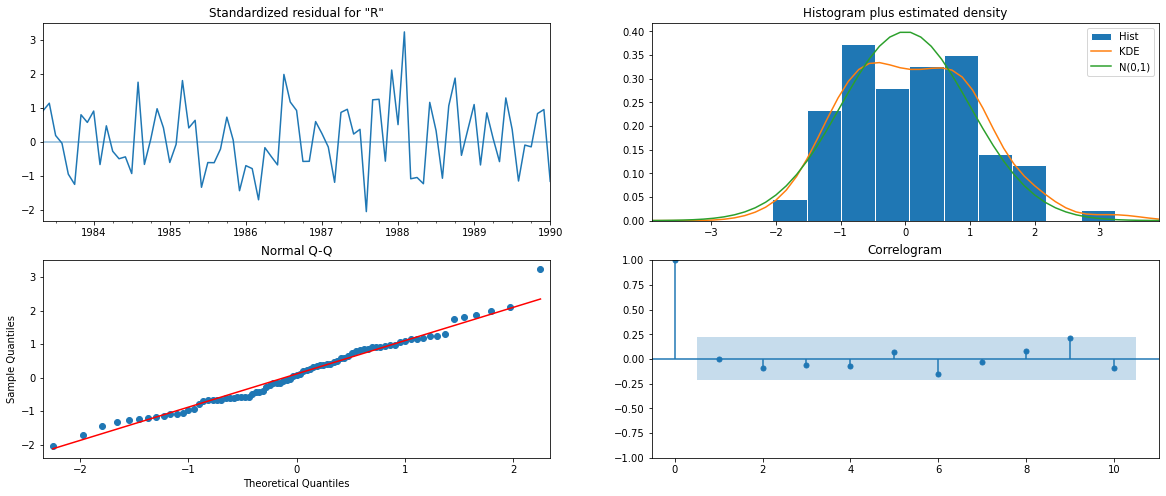

In [80]:
results_auto_SARIMA.plot_diagnostics();

## Predict on the Test Set using this model and evaluate the model.

In [81]:
predicted_auto_SARIMA = results_auto_SARIMA.forecast(steps=len(test))

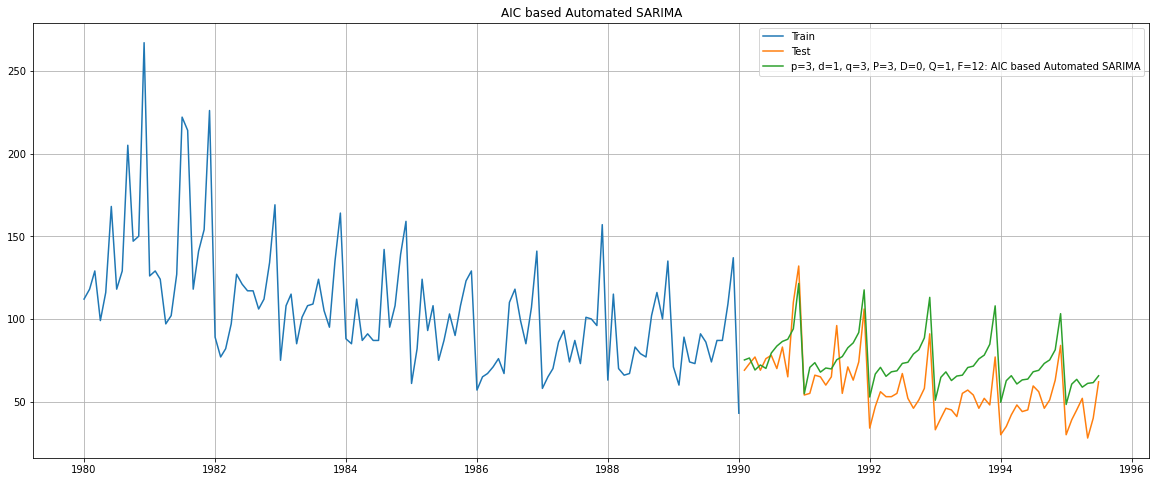

In [82]:
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.plot(predicted_auto_SARIMA, label='p=3, d=1, q=3, P=3, D=0, Q=1, F=12: AIC based Automated SARIMA')
plt.legend(loc='best')
plt.grid()
plt.title('AIC based Automated SARIMA');

In [83]:
rmse = mean_squared_error(test['Rose'], predicted_auto_SARIMA, squared=False)
print('RMSE:',rmse)

RMSE: 18.895456191372848


In [84]:
temp_resultsDf = pd.DataFrame({'RMSE': rmse}, index=['AUTO SARIMA (3,1,3)(3,0,1,12)'])
resultsDf = pd.concat([resultsDf,temp_resultsDf])
resultsDf

,RMSE
LR,16.408496
Naive,25.079948
Average,51.865744
SES (0.098),35.021108
"DES ((1.49, 3.95))",16.408496
"TES A (0.086, 4.071, 0.00)",13.887554
"TES M (0.079, 0.038, 0.001)",18.480138
"AUTO ARIMA (2, 1, 3)",34.434488
"MANUAL ARIMA (2, 1, 2)",34.382361
"AUTO SARIMA (3,1,3)(3,0,1,12)",18.895456


## Build a version of the SARIMA model for which the best parameters are selected by looking at the ACF and the PACF plots. - Seasonality at 12.

Let us look at the ACF and the PACF plots once more.

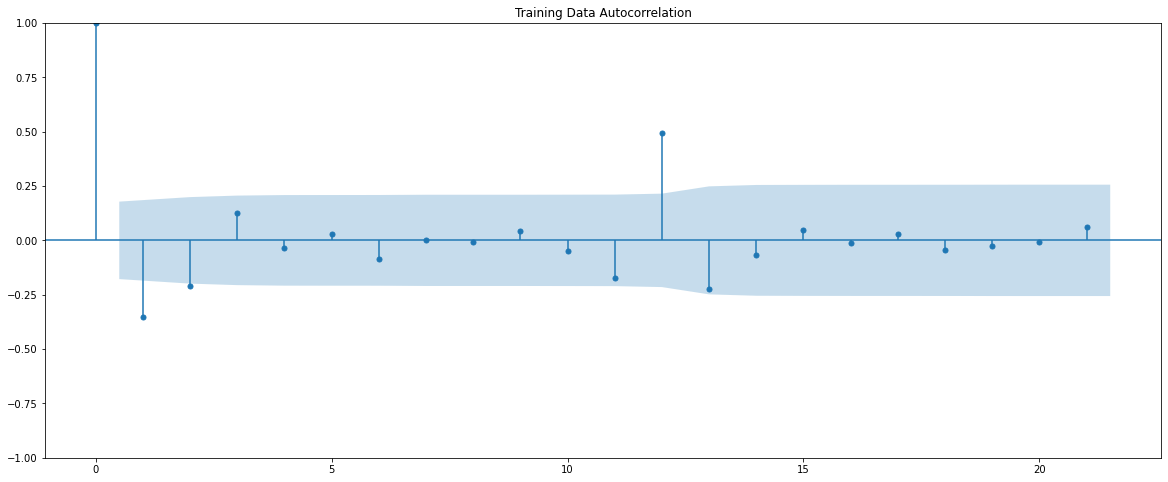

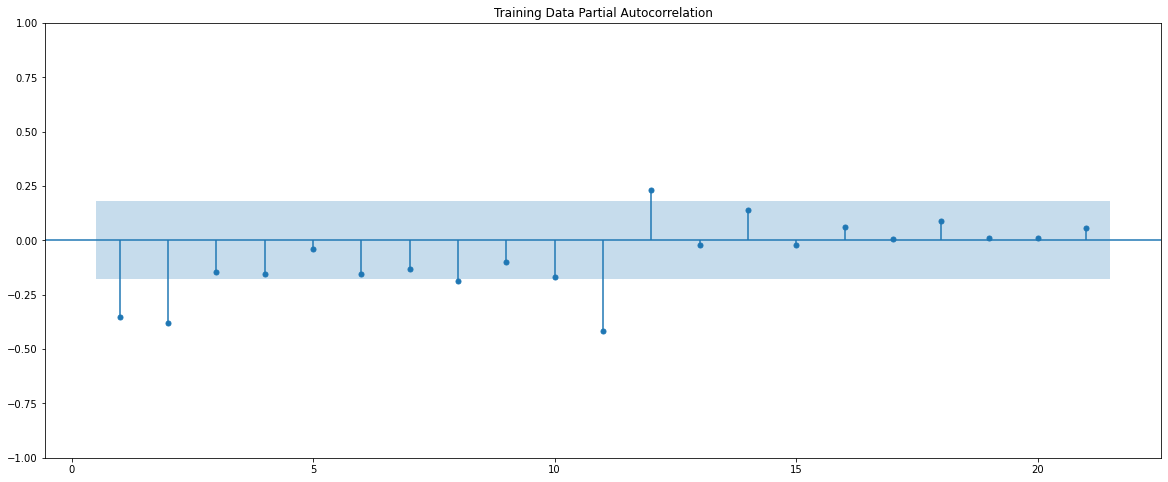

In [85]:
plot_acf(train.diff(),title='Training Data Autocorrelation',missing='drop')
plot_pacf(train.diff().dropna(),title='Training Data Partial Autocorrelation',zero=False,method='ywmle');

Here, we have taken alpha=0.05.

We are going to take the seasonal period as 12.
We are taking the p value to be 2 and the q value also to be 2 as the parameters same as the ARIMA model.

In [86]:
import statsmodels.api as sm
manual_SARIMA = sm.tsa.statespace.SARIMAX(train['Rose'],
                                order=(2,1,2),
                                seasonal_order=(1, 0, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results_manual_SARIMA = manual_SARIMA.fit(maxiter=1000)
print(results_manual_SARIMA.summary())

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                                      SARIMAX Results                                       
Dep. Variable:                                 Rose   No. Observations:                  121
Model:             SARIMAX(2, 1, 2)x(1, 0, [1], 12)   Log Likelihood                -473.569
Date:                              Sun, 19 Feb 2023   AIC                            961.138
Time:                                      17:16:08   BIC                            979.716
Sample:                                  01-01-1980   HQIC                           968.666
                                       - 01-01-1990                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.1532      0.114     10.152      0.000       0.931       1.376
ar.L2         -0.29

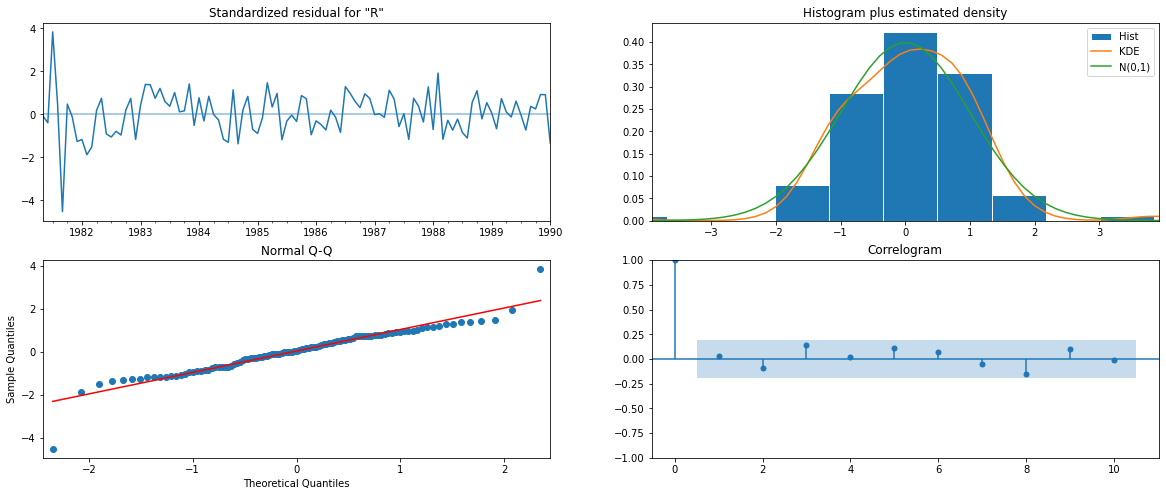

In [87]:
results_manual_SARIMA.plot_diagnostics()
plt.show()

## Predict on the Test Set using this model and evaluate the model.

In [88]:
predicted_manual_SARIMA = results_manual_SARIMA.forecast(steps=len(test))

Text(0.5, 1.0, 'ACF and PACF plots based manual SARIMA')

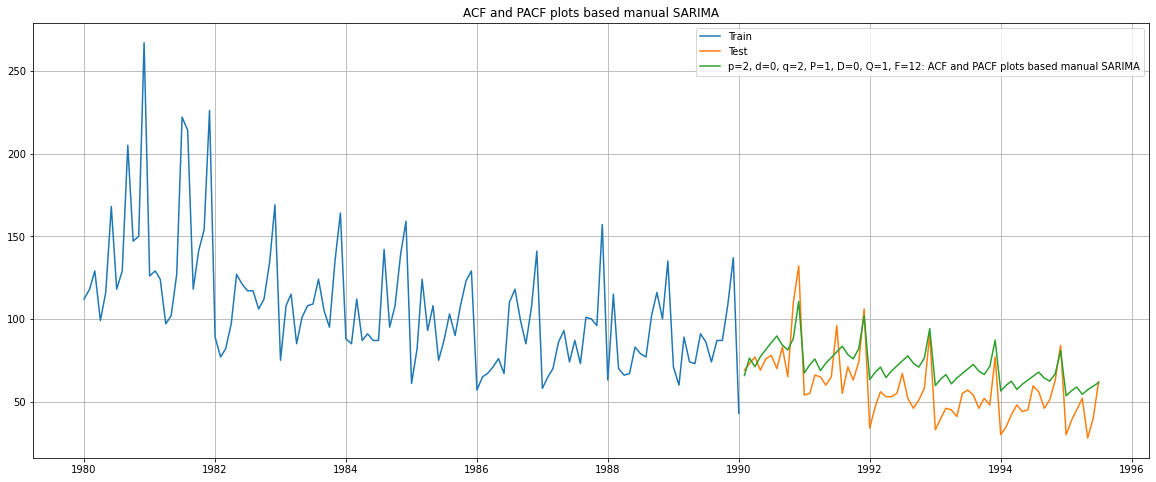

In [89]:
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.plot(predicted_manual_SARIMA, label='p=2, d=0, q=2, P=1, D=0, Q=1, F=12: ACF and PACF plots based manual SARIMA')
plt.legend(loc='best')
plt.grid()
plt.title('ACF and PACF plots based manual SARIMA')

In [90]:
rmse = mean_squared_error(test['Rose'],predicted_manual_SARIMA,squared=False)
print('RMSE:',rmse)

RMSE: 16.640441513951473


In [91]:
temp_resultsDf = pd.DataFrame({'RMSE': [rmse]},index=['MANUAL SARIMA (2,1,2)(1,0,1,12)'])
resultsDf = pd.concat([resultsDf,temp_resultsDf])
resultsDf

,RMSE
LR,16.408496
Naive,25.079948
Average,51.865744
SES (0.098),35.021108
"DES ((1.49, 3.95))",16.408496
"TES A (0.086, 4.071, 0.00)",13.887554
"TES M (0.079, 0.038, 0.001)",18.480138
"AUTO ARIMA (2, 1, 3)",34.434488
"MANUAL ARIMA (2, 1, 2)",34.382361
"AUTO SARIMA (3,1,3)(3,0,1,12)",18.895456


## Building the most optimum model on the Full Data.

## Most Optimum Model is TES A

In [92]:
model_TES_aa_full = ExponentialSmoothing(df,trend='add',seasonal='additive',initialization_method='estimated')
model_TES_aa_full = model_TES_aa_full.fit()
model_TES_aa_full.params

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


{'smoothing_level': 0.11445420685611252,
 'smoothing_trend': 2.837041929224345e-05,
 'smoothing_seasonal': 0.0006610051964071723,
 'damping_trend': nan,
 'initial_level': 145.0170227521522,
 'initial_trend': -0.5255377667749839,
 'initial_seasons': array([-28.21562221, -17.37014271,  -9.28387252, -15.95866881,
        -12.06365075,  -6.02056525,   6.0042937 ,   5.83895906,
          2.5014465 ,   1.76244379,  16.88882471,  55.68877289]),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

## Predict 12 months into the future.

In [93]:
predicted_TES_A_full_data = model_TES_aa_full.forecast(steps=12)

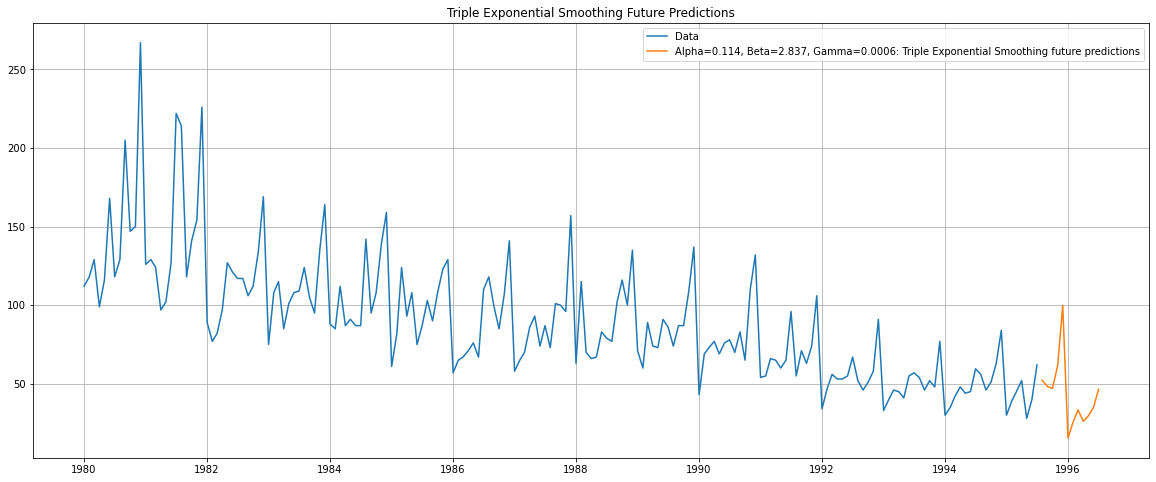

In [94]:
plt.plot(df, label='Data')
plt.plot(predicted_TES_A_full_data, label='Alpha=0.114, Beta=2.837, Gamma=0.0006: Triple Exponential Smoothing future predictions')
plt.legend(loc='best')
plt.grid()
plt.title('Triple Exponential Smoothing Future Predictions');

In [95]:
predicted_12_month_data = predicted_TES_A_full_data

In [96]:
predicted_12_month_data.describe()

count    12.000000
mean     43.410793
std      22.154558
min      15.477758
25%      28.685156
50%      40.791141
75%      49.262286
max      99.906848
dtype: float64

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

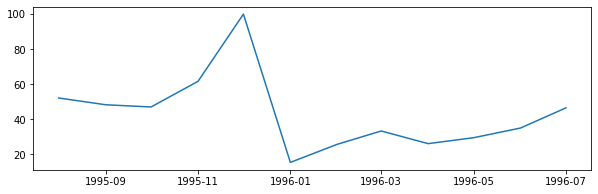

In [97]:
rcParams['figure.figsize'] = 10,3
sns.lineplot(predicted_12_month_data.index, predicted_12_month_data)


In [98]:
available_last_12_month_data = df[-12:]

In [99]:
available_last_12_month_data.describe()

,Rose
count,12.000000
mean,49.666667
std,15.534907
min,28.000000
25%,39.750000
50%,48.500000
75%,57.500000
max,84.000000


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='YearMonth'>

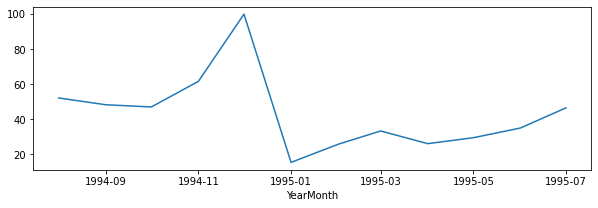

In [100]:
sns.lineplot(available_last_12_month_data.index, predicted_12_month_data)

# END